In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt,prod

import demeter.utils.torchbox as tb
import demeter.utils.vector_field_to_flow as vff
from demeter.utils.constants import *
%load_ext autoreload
%autoreload 2
import demeter.utils.reproducing_kernels as rk
import demeter.metamorphosis as mt


def tp(x):
    """ prepare simplex tensor to be plotted as an image
    
    """
    tp_img = x[0].permute(1,2,0).cpu().numpy()
    if tp_img.shape[-1] in [3,4]:
        return tp_img
    elif tp_img.shape[-1] == 2:
        z_shape = tp_img.shape[:-1]
        zero = np.zeros(z_shape + (1,))
        return np.concatenate(
            [tp_img,zero],axis=-1
        )
    
def to_plot(img):
    if img.shape[-1] == 3:
        return img
    elif img.shape[-1] == 4:
        return img[...,:-1]

def make_exp(xxx, yyy, centre, sigma, threshold):
    ce_x, ce_y = centre
    sigma_x,sigma_y = sigma
    exp = torch.exp(
        - ((xxx - ce_x) / sigma_x) ** 2
        - ((yyy - ce_y) / sigma_y) ** 2
    ) > threshold
    return exp


## Residual métric
        
def get_deformator(mp,from_t=0,to_t=None,save=False):
    temporal_integrator = vff.FieldIntegrator(method='temporal',save=save)
    if from_t is None and to_t is None:
        print('Je suis passé par là')
        return temporal_integrator(mp.field_stock/mp.n_step, forward=False)
    # if from_t is None: from_t = 0
    if to_t is None: to_t = mp.n_step 
    if from_t < 0 and from_t >= to_t: 
        raise ValueError(f"from_t must in [0,n_step-1], got from_t ={from_t} and n_step = {mp.n_step}")
    if to_t > mp.n_step: 
        raise ValueError(f"to_t must in [from_t+1,n_step], got to_t ={to_t} and n_step = {mp.n_step}")
    if to_t==1:
        return mp.id_grid.detach().cpu() - mp.field_stock[0][None].detach().cpu() / mp.n_step
    # ic(from_t,to_t,mp.field_stock[from_t:to_t].shape)
    return temporal_integrator(mp.field_stock[from_t:to_t]/mp.n_step, forward=False)
    
# Plot visu registration:
def get_resi_cumul_onTarget(mr, debug = False ) :
    resi_sum = torch.zeros_like(mr.target)
    N = mr.mp.residuals_stock.shape[0]
    if debug:
        fig,ax = plt.subplots(2,N,figsize=(5*N,10),constrained_layout=True)
    
    for i in range(N):
        deform_t = get_deformator(mr.mp,from_t=i,save=False)
        # ic(mr.mp.residuals_stock[i].min(),mr.mp.residuals_stock[i].max())
        resi_sum += sqrt(1 - mr._get_rho_()) * tb.imgDeform(mr.mp.residuals_stock[i][None], deform_t,dx_convention="pixel") / mr.mp.n_step
        # ic(resi_sum.min(),resi_sum.max())
        if debug:
            to_show_r = resi_sum.squeeze().permute(1,2,0).numpy()
            ax[0,i].imshow(to_show_r[...,:-1])
            ax[1,i].imshow(mr.mp.residuals_stock[i].squeeze().permute(1,2,0).numpy()[...,:-1])
            set_ticks_off(ax)
    return resi_sum    
    
def residual_quality_metric(mr,resi_rhoInfty):
    resi_sum = get_resi_cumul_onTarget(mr,debug=False)
    return torch.sum((resi_sum - resi_rhoInfty ) ** 2)
    
def plot_endresult(mr,save=False, return_all=False,filename=None):
    image_ts = tp(mr.mp.image) **2
    # momentum_ts = mr.mp.momentum.permute(0,2,3,1).squeeze().cpu().detach().numpy()
    momentum_ts = tp(mr.mp.momentum)    
    
    # ic(image_ts.shape)
    residual_cumul = get_resi_cumul_onTarget(mr,debug=False)#.cpu().permute(0,2,3,1)[0]
    # print('residual_cumul.shape:',residual_cumul.shape)
    # residual_cumul = residual_cumul.sum(dim=-1)
    # residual_cumul = residual_cumul
    #residual_ts = mr.mp.residuals.squeeze().permute(1,2,0).numpy() 
    
    deform = mr.mp.get_deformation()
    # print("source dtype",source.dtype)
    # print("deformator",mr.mp.get_deformator().dtype)
    im_deformed_only = tb.imgDeform(source.to('cpu'),mr.mp.get_deformator().cpu(),dx_convention="pixel")
    im_deformed_only = tp(im_deformed_only) 
    
    diff_im_t = np.sum(np.abs(image_ts-tp(target)),axis=-1)
    diff_im_def = np.sum(np.abs(im_deformed_only-tp(target)),axis=-1)

    metric_ssd = np.sqrt(np.sum((image_ts-tp(target))**2))
    metric_sdd_def_only = np.sqrt(np.sum((im_deformed_only-tp(target))**2))

    fig,ax = plt.subplots(3,3,figsize=(10,10),constrained_layout=True)
    fig.suptitle(mr.mp, fontsize=16)
    ax[0,0].imshow(tp(source))
    ax[0,0].set_title("Source")
    ax[0,1].imshow(tp(target))
    ax[0,1].set_title("Target")
    
    step = max(1,deform.shape[1]//15)
    tb.gridDef_plot_2d(deform,step=step,ax=ax[0,2],check_diffeo=False,origin = 'upper')
    
    
    ax[1,1].imshow(image_ts)
    ax[1,1].set_title("Image")
    ax[1,0].imshow(momentum_ts)
    ax[1,0].set_title("Momentum")
    # ic(residual_cumul.shape)
    # ic(residual_cumul.dtype)
    d = ax[1,2].imshow(tp(residual_cumul))
    fig.colorbar(d, ax=ax[1,2])
    ax[1,2].set_title("Cumulative residual")
    
    ax[2,0].imshow(im_deformed_only)
    ax[2,0].set_title(f"only Deformed Source")
    d = ax[2,1].imshow(diff_im_t,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,1])
    ax[2,1].set_title(f"Diff Image Target = {metric_ssd:.2f}")
    d = ax[2,2].imshow(diff_im_def,cmap="RdYlGn_r")
    fig.colorbar(d, ax=ax[2,2])
    ax[2,2].set_title(f"Diff Image only deformed m = {metric_sdd_def_only:.2f}")
    
    
    set_ticks_off(ax)
    if save:
        if filename is None:
            filename = f"{path_save}{name}_{mr.mp.kernelOperator.sigma_continuous.tolist()}_summary.png"
        else:
            filename = f"{path_save}{filename}.png"
        plt.savefig(filename)
    
    if return_all:
        return {"metric_ssd" : metric_ssd,
                "metric_sdd_def_only" : metric_sdd_def_only,
                "im_deformed_only" : im_deformed_only,
                "image_ts" : image_ts,
                "momentum_ts" : momentum_ts,
                "residual_cumul" : residual_cumul
                }
    else:
        return metric_ssd,metric_sdd_def_only
    
device = 'cuda:0'
# plot_endresult(mr,save=False, return_all=True)
# plt.show()

/home/turtlefox/anaconda3/envs/gliomorph/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/demeter/utils/reproducing_kernels.py:229: SyntaxWarning: invalid escape sequence '\s'
  axes[1].set_title(f'Gaussian Kernel $\sigma$={sigma}')
/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/demeter/utils/reproducing_kernels.py:612: SyntaxWarning: invalid escape sequence '\s'
  """The function get_sigma_from_img_ratio calculates the ideal


# Build images : design and visualization
## Experience 1: Déformation pure

tensor(0.0573)


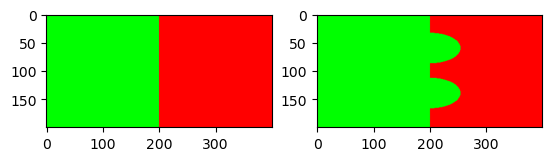

In [2]:

def experience_1(size,sigma):
    H,W = size
    
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
    
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = xx >= .5
    image[0,1] = (xx <.5)
    
    moving = image.clone()
    
    # add exps
    sigma_exp = (sigma,sigma)
    exp_1 = make_exp(xx,yy,(.5,.7),sigma_exp,1./(2*torch.pi))
    exp_2 = make_exp(xx,yy,(.5,.3),sigma_exp,1./(2*torch.pi))
    
    mask_x = image[0,0] == 1
    add_exp = torch.zeros_like(mask_x)
    add_exp[mask_x] = (exp_1 + exp_2)[mask_x]
    sum_exp = add_exp.sum()/(H*W)
    print(sum_exp)
    image[0,1] += add_exp
    image[0,0] -= add_exp.to(int)
    fixed = image.clone()
    return moving,fixed

source,target = experience_1((200,400),.1)

name = 'add_vol_sigma'
path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)

%matplotlib inline

fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
plt.show()

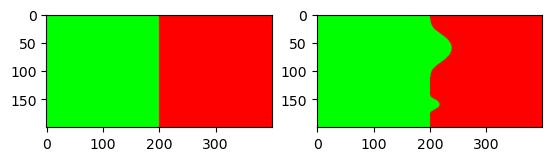

In [5]:
def make_exp_A(xxx, yyy, centre, sigma):
    ce_x, ce_y = centre
    sigma_x,sigma_y = sigma
    exp = torch.exp(
    - 0.5*((xxx - ce_x) / sigma_x) ** 2
    - 0.5*((yyy - ce_y) / sigma_y) ** 2)
    return exp

def experience_1(size,sigma):
    H,W = size
    
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
    
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    image[0,0] = xx >= .5
    image[0,1] = (xx <.5)
    
    moving = image.clone()
    
    # add exps
    sigma_exp1 = (0.3*sigma,0.3*sigma)
    sigma_exp2 = (sigma,sigma)
    exp = make_exp_A(xx,yy,(.5,.8),sigma_exp1)
    exp += make_exp_A(xx,yy,(.5,.3),sigma_exp2)
    
    image[0,1] = (xx-0.2*exp)<0.5
    image[0,0] =1 - image[0,1]
    fixed = image.clone()
    name = 'add_vol_sigma'
    return moving,fixed, name

source,target, name = experience_1((200,400),.08)


# path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
# if not os.path.exists(path_save):

%matplotlib inline

fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
plt.show()

In [ ]:
# def experience_1(size,sigma):
#     H,W = size
#     
#     id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
#     xx,yy = id_grid[0,...,0], id_grid[0,...,1]
#     
#     ## Background simplex
#     image = torch.zeros((1,2,H,W))
#     image[0,0] = xx >= .5
#     image[0,1] = (xx <.5)
#     
#     moving = image.clone()
#     
#     # add exps
#     sigma_exp = (sigma,sigma)
#     exp_1 = make_exp(xx,yy,(.5,.7),sigma_exp,1./(2*torch.pi))
#     exp_2 = make_exp(xx,yy,(.5,.3),sigma_exp,1./(2*torch.pi))
#     
#     mask_x = image[0,0] == 1
#     add_exp = torch.zeros_like(mask_x)
#     add_exp[mask_x] = (exp_1 + exp_2)[mask_x]
#     sum_exp = add_exp.sum()/(H*W)
#     print(sum_exp)
#     image[0,1] += add_exp
#     image[0,0] -= add_exp.to(int)
#     fixed = image.clone()
#     return moving,fixed

# source,target = experience_1((200,400),.1)

import demeter.utils.bspline as bs

cms = torch.tensor([
    [
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,1,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
    ],
    [
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0],
    ]
])
bs.field2D_bspline()

name = 'add_vol_sigma'
path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)

%matplotlib inline

fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
plt.show()

## Experience 2: Ajout photométrique pur

aire du disque : tensor(0.0717)


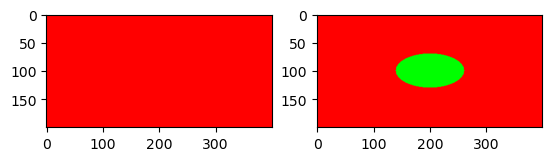

In [102]:
def experience_2(size,sigma_exp):
    H,W = size
    
    id_grid = tb.make_regular_grid((H,W),dx_convention = 'square')
    xx,yy = id_grid[0,...,0], id_grid[0,...,1]
    
    ## Background simplex
    image = torch.zeros((1,2,H,W))
    # image[0,0] = xx >= .5
    # image[0,1] = (xx <.5)
    
    moving = torch.stack(
        [
            torch.ones((H,W)),
            torch.zeros((H,W)),
        ],dim=0
    )[None]
    
    # add exps
    sigma_exp = (sigma_exp,sigma_exp)
    exp_1 = make_exp(xx,yy,(.5,.5),sigma_exp,.1)
    # exp_2 = make_exp(xx,yy,(.5,.3),sigma_exp,.1)
    
    
    sum_exp = exp_1.sum()/(H*W)
    print("aire du disque :",sum_exp)
    image[0,1] = exp_1
    image[0,0] = 1 - exp_1.to(int)
    fixed = image.clone()
    
    name = 'add_resi_sigma'
    return moving,fixed, name

source,target,name = experience_2((200,400),.1)

path_save = ROOT_DIRECTORY + f"/examples/results/simplex_result/{name}/"
if not os.path.exists(path_save):
    os.makedirs(path_save)

%matplotlib inline

fig,ax = plt.subplots(1,2)
ax[0].imshow(tp(source))
ax[1].imshow(tp(target))
plt.show()

# Parameters variations

## Make sigma vary

### run registration

s_list: tensor([0.0500, 0.0589, 0.0678, 0.0767, 0.0856, 0.0944, 0.1033, 0.1122, 0.1211,
        0.1300])

s: 0.05000000074505806<<<<<<<<<<
kernel_h : torch.Size([1, 59]), kernel_w : torch.Size([1, 119])
torch.Size([1, 59])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([ 9.9500, 19.9500])
	sigma_continous :tensor([0.0500, 0.0500])
	kernel_size :(1, 59, 119)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:02s and 0.850cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}]




/tmp/ipykernel_92281/2947935270.py:147: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


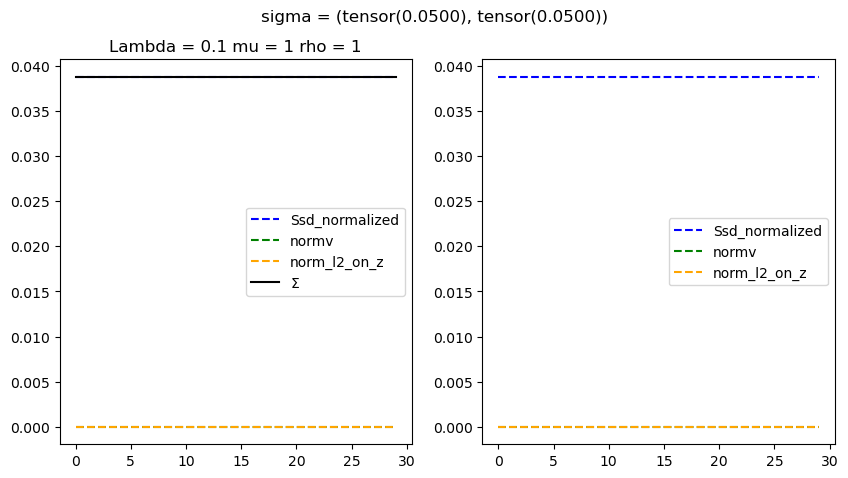

/home/turtlefox/anaconda3/envs/gliomorph/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


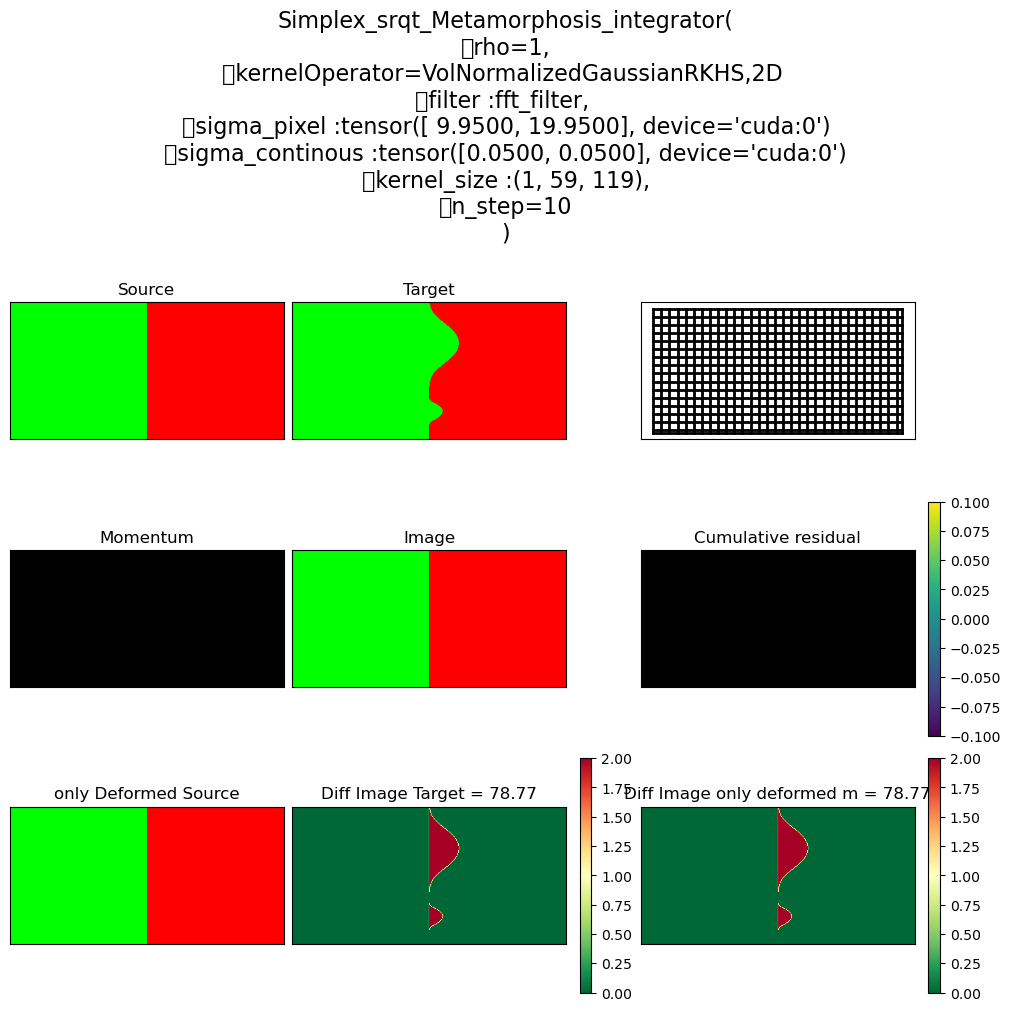


s: 0.058888889849185944<<<<<<<<<<
kernel_h : torch.Size([1, 71]), kernel_w : torch.Size([1, 141])
torch.Size([1, 71])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([11.7189, 23.4967])
	sigma_continous :tensor([0.0589, 0.0589])
	kernel_size :(1, 71, 141)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.845cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 

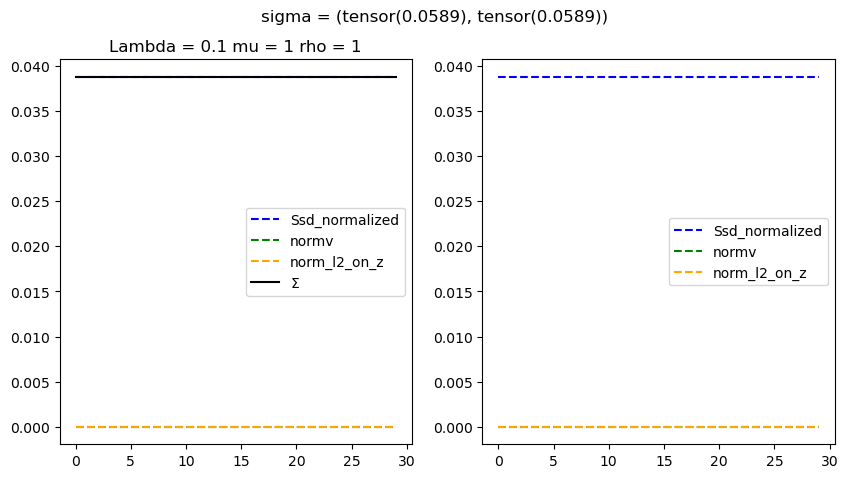

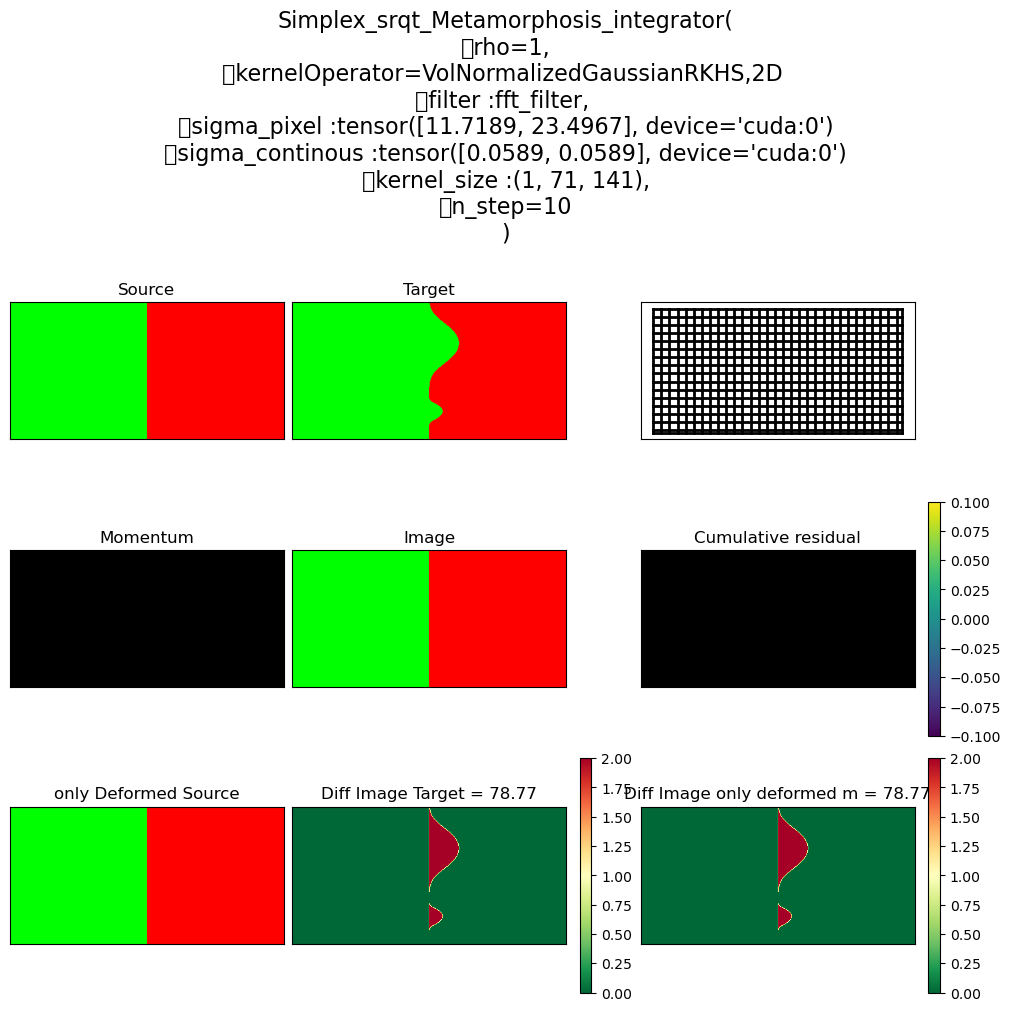


s: 0.06777778267860413<<<<<<<<<<
kernel_h : torch.Size([1, 81]), kernel_w : torch.Size([1, 163])
torch.Size([1, 81])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([13.4878, 27.0433])
	sigma_continous :tensor([0.0678, 0.0678])
	kernel_size :(1, 81, 163)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.728cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), '

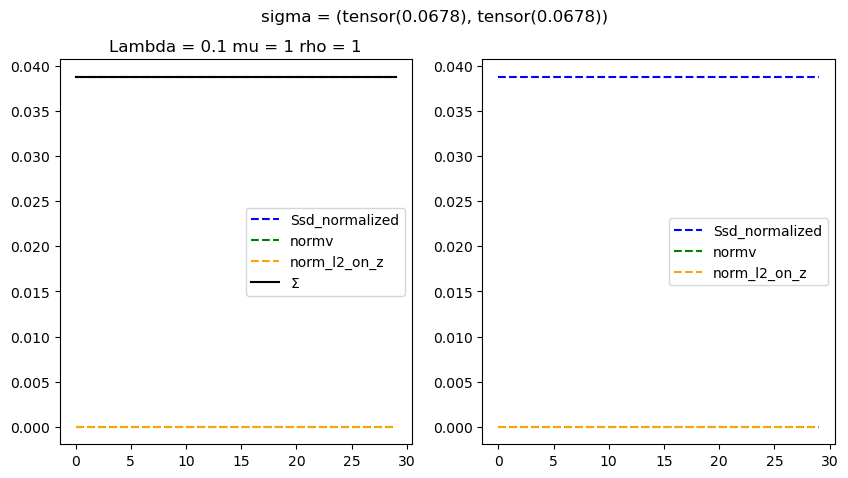

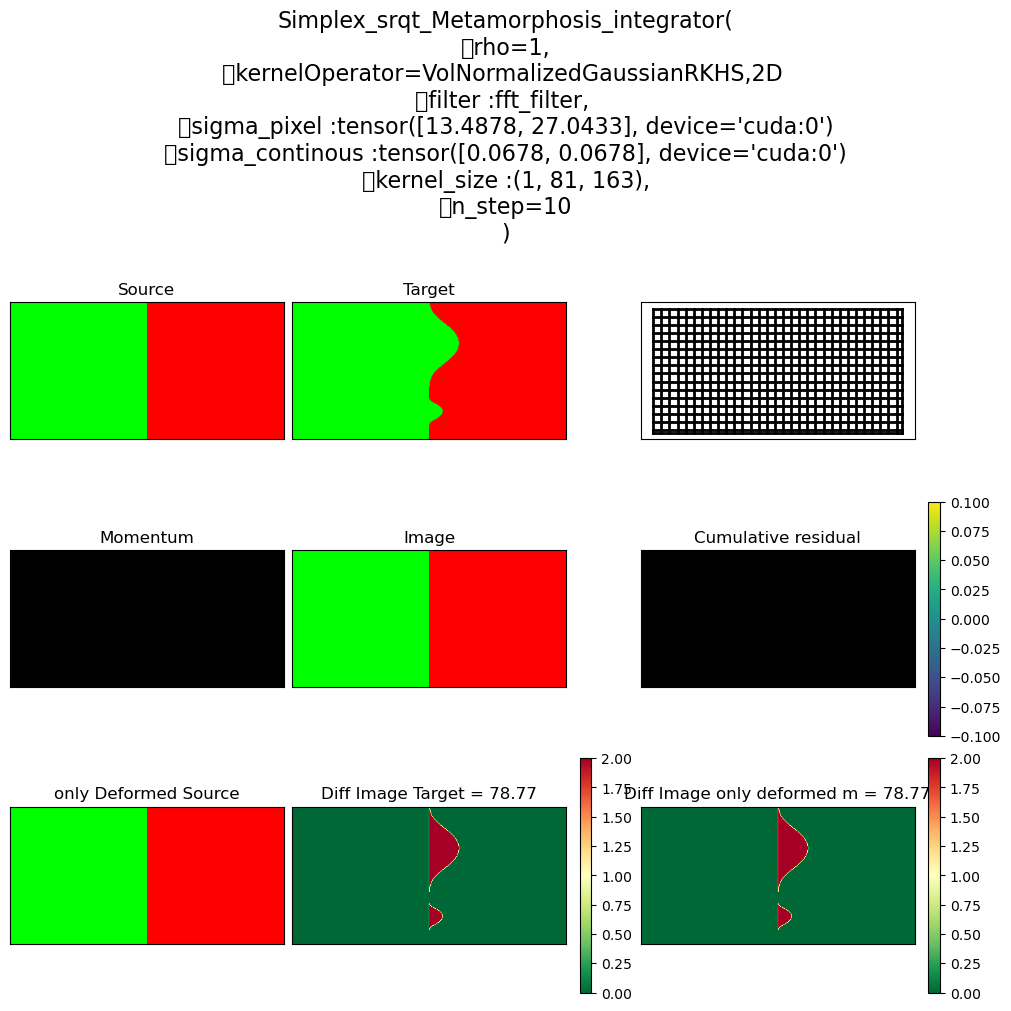


s: 0.07666666805744171<<<<<<<<<<
kernel_h : torch.Size([1, 91]), kernel_w : torch.Size([1, 183])
torch.Size([1, 91])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([15.2567, 30.5900])
	sigma_continous :tensor([0.0767, 0.0767])
	kernel_size :(1, 91, 183)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.720cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), '

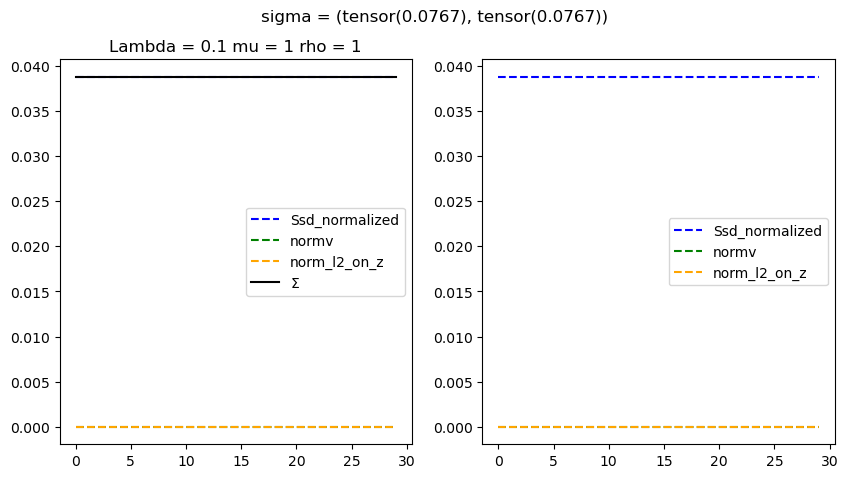

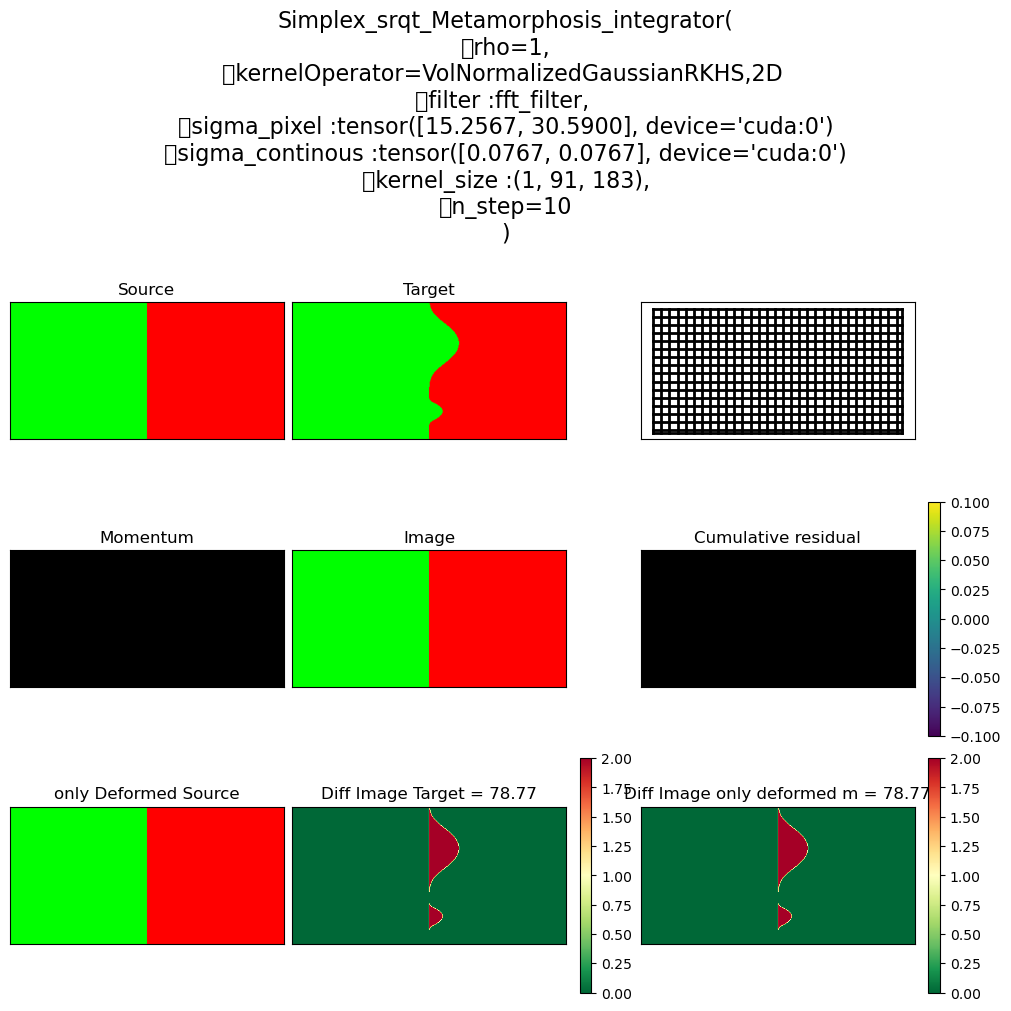


s: 0.0855555534362793<<<<<<<<<<
kernel_h : torch.Size([1, 103]), kernel_w : torch.Size([1, 205])
torch.Size([1, 103])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([17.0256, 34.1367])
	sigma_continous :tensor([0.0856, 0.0856])
	kernel_size :(1, 103, 205)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.700cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>),

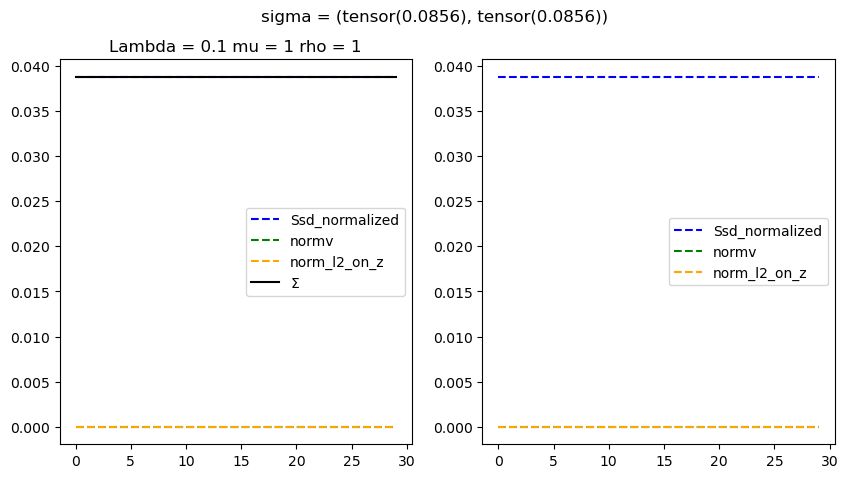

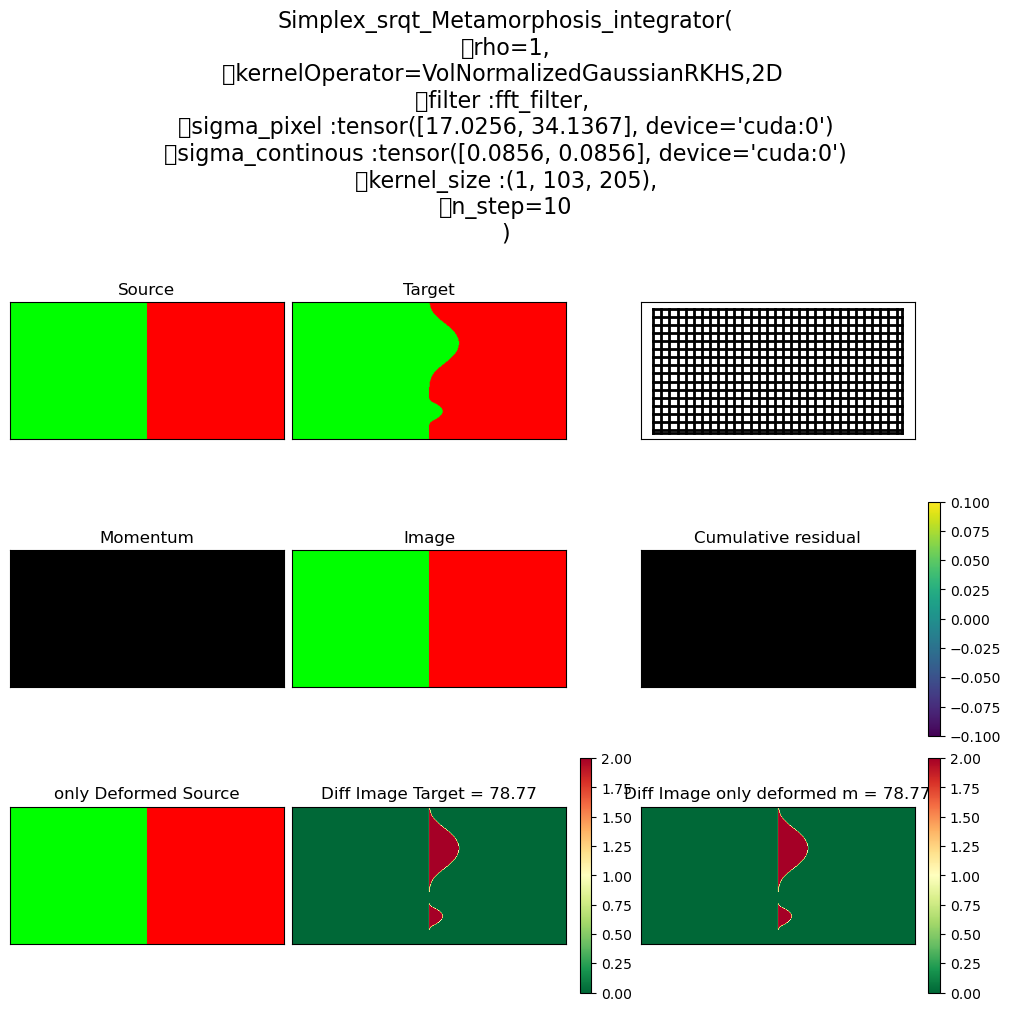


s: 0.09444443881511688<<<<<<<<<<
kernel_h : torch.Size([1, 113]), kernel_w : torch.Size([1, 227])
torch.Size([1, 113])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([18.7944, 37.6833])
	sigma_continous :tensor([0.0944, 0.0944])
	kernel_size :(1, 113, 227)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.870cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

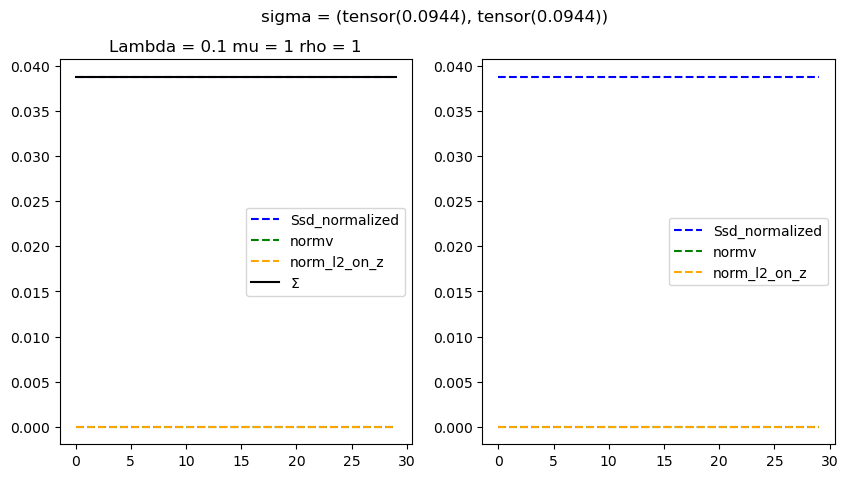

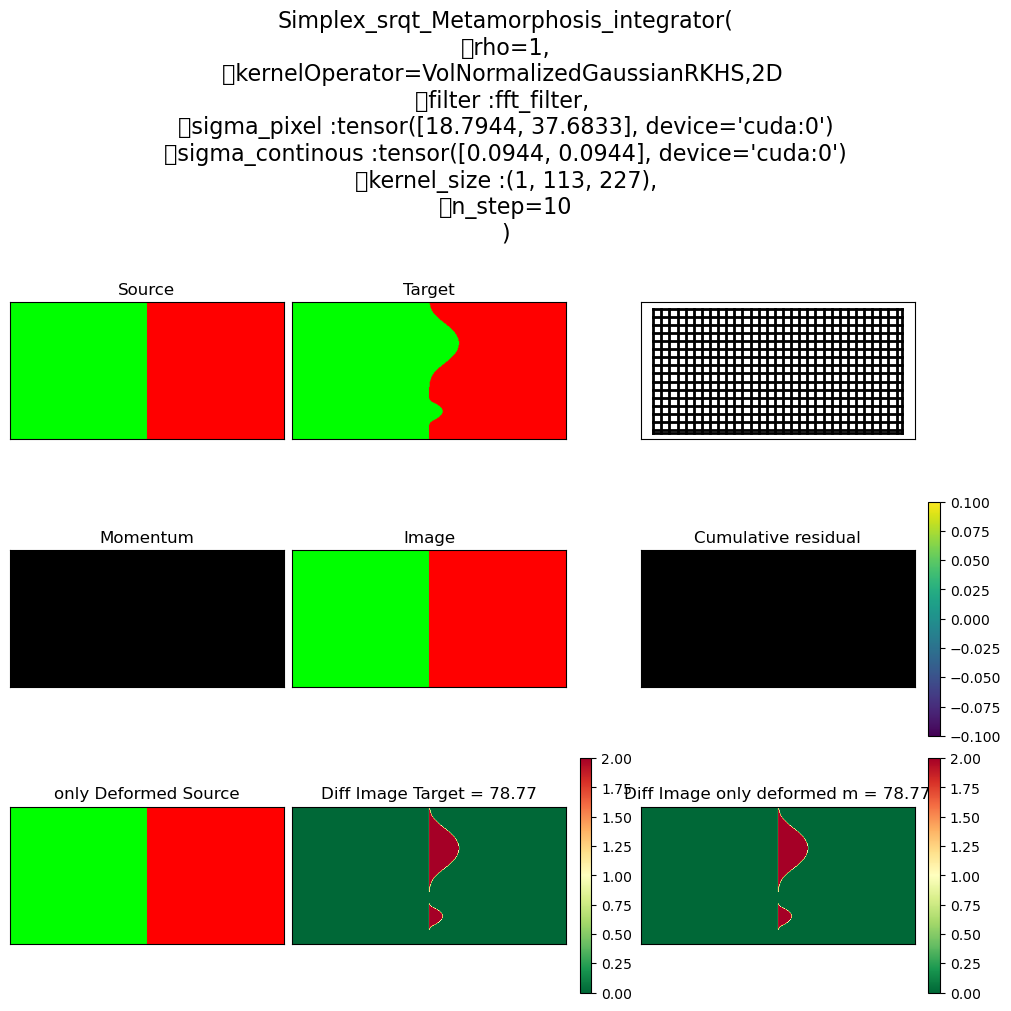


s: 0.10333332419395447<<<<<<<<<<
kernel_h : torch.Size([1, 123]), kernel_w : torch.Size([1, 247])
torch.Size([1, 123])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([20.5633, 41.2300])
	sigma_continous :tensor([0.1033, 0.1033])
	kernel_size :(1, 123, 247)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.930cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

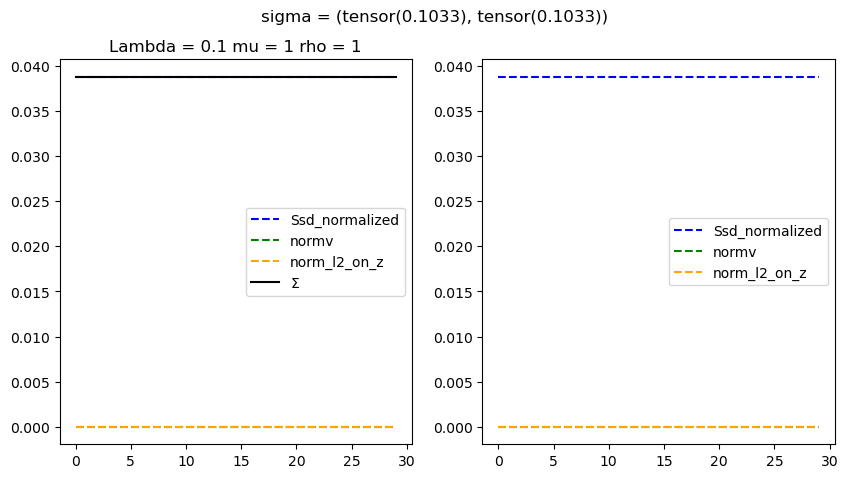

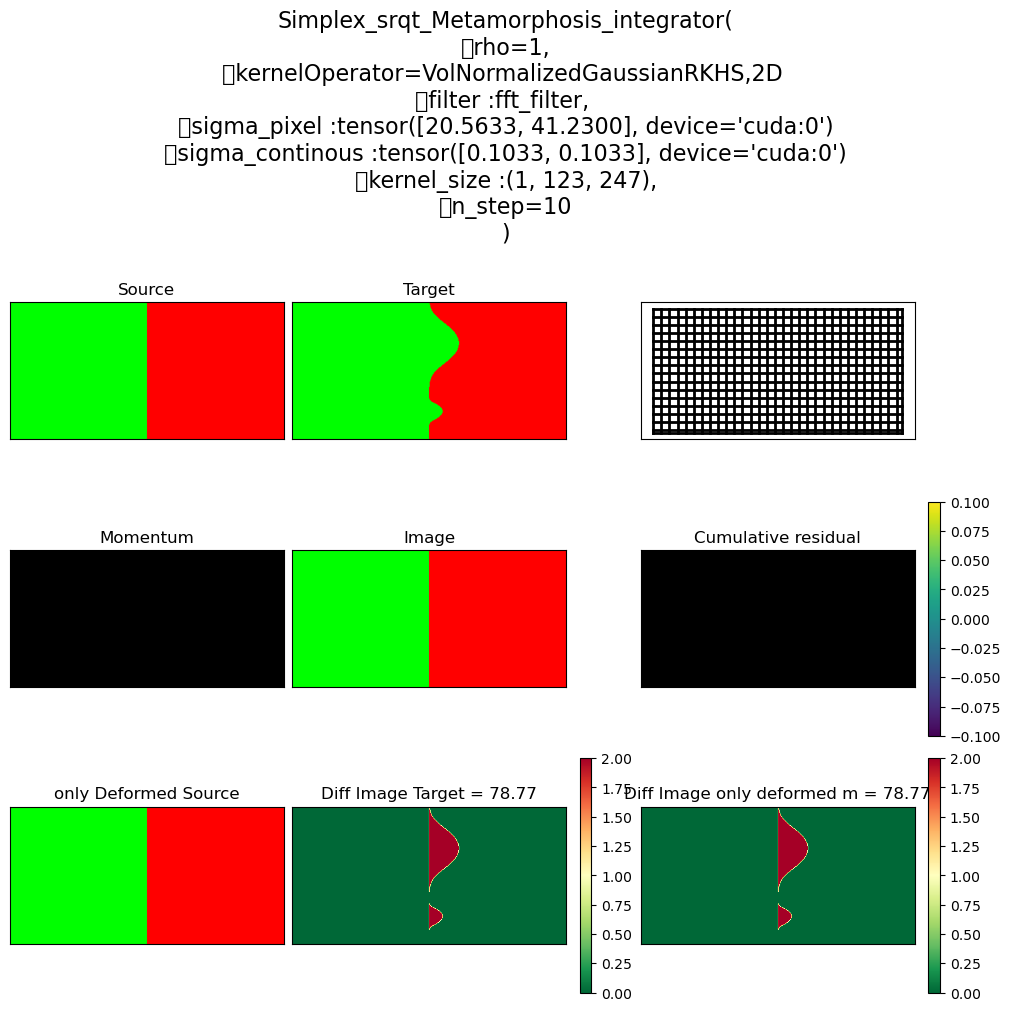


s: 0.11222221702337265<<<<<<<<<<
kernel_h : torch.Size([1, 133]), kernel_w : torch.Size([1, 269])
torch.Size([1, 133])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([22.3322, 44.7767])
	sigma_continous :tensor([0.1122, 0.1122])
	kernel_size :(1, 133, 269)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:01s and 0.882cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

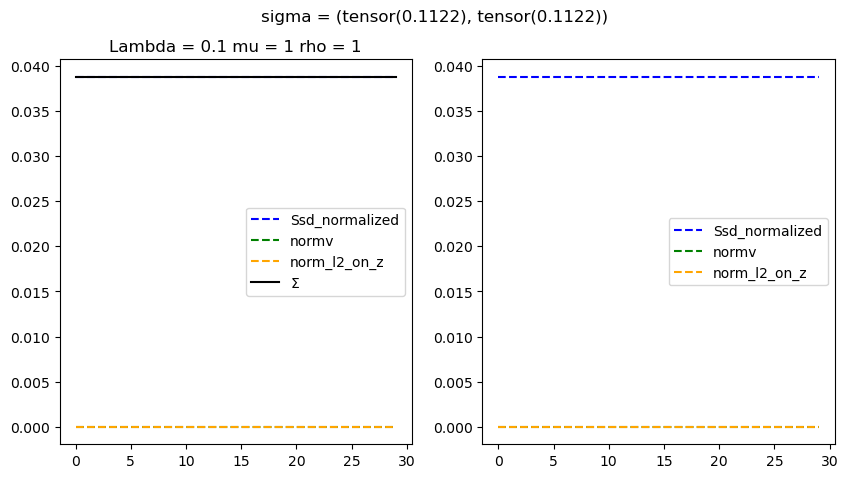

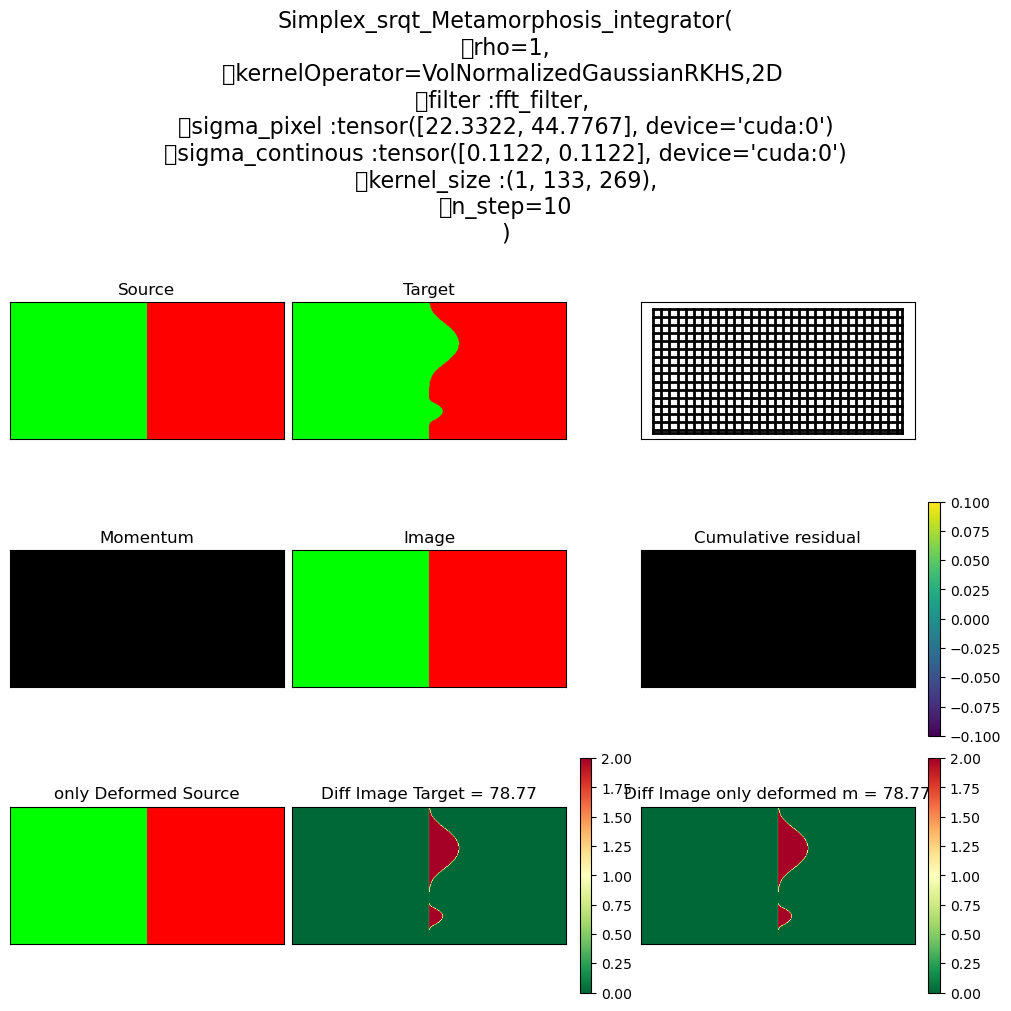


s: 0.12111110985279083<<<<<<<<<<
kernel_h : torch.Size([1, 145]), kernel_w : torch.Size([1, 289])
torch.Size([1, 145])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([24.1011, 48.3233])
	sigma_continous :tensor([0.1211, 0.1211])
	kernel_size :(1, 145, 289)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:02s and 0.053cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

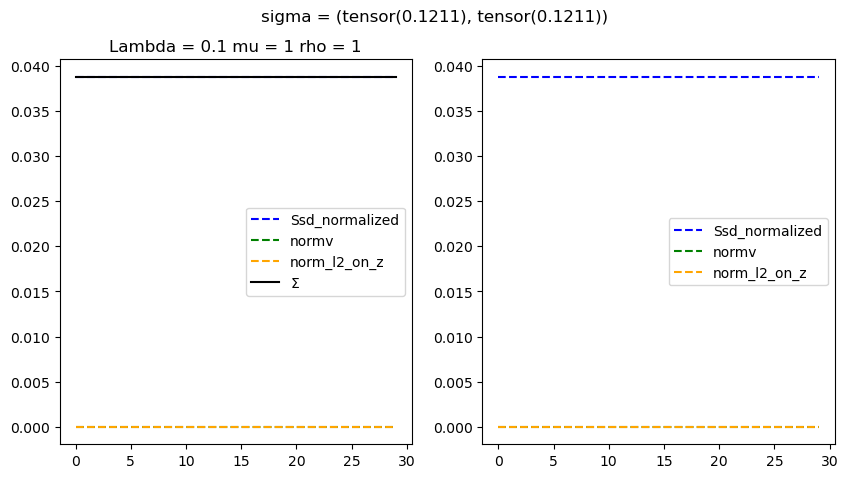

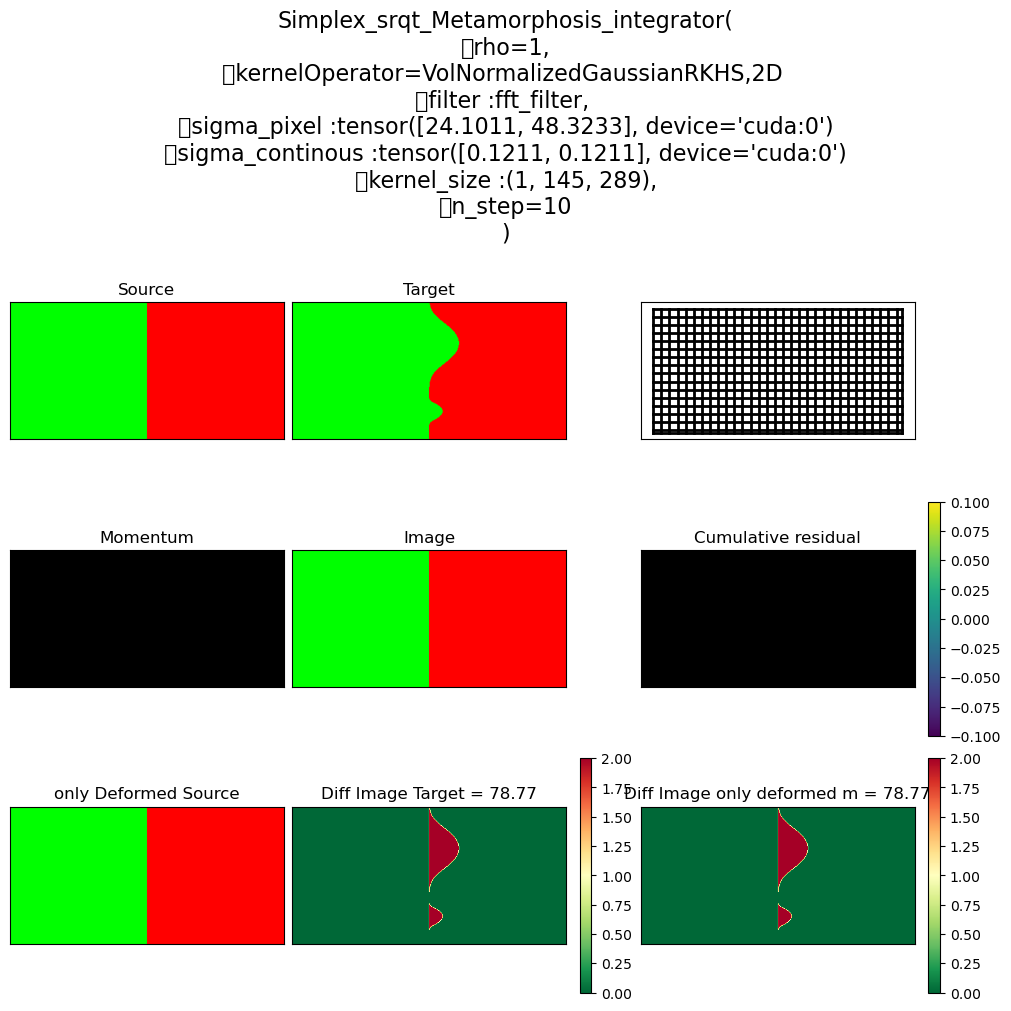


s: 0.12999999523162842<<<<<<<<<<
kernel_h : torch.Size([1, 155]), kernel_w : torch.Size([1, 311])
torch.Size([1, 155])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([25.8700, 51.8700])
	sigma_continous :tensor([0.1300, 0.1300])
	kernel_size :(1, 155, 311)
dx = (0.005025125628140704, 0.002506265664160401)

Computation of forward done in  0:00:02s and 0.009cents  s
[{'sigma_pixel': tensor([ 9.9500, 19.9500], device='cuda:0'), 'sigma_continuous': tensor([0.0500, 0.0500], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'rho': 1, 'total_cost': tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)}, {'sigma_pixel': tensor([11.7189, 23.4967], device='cuda:0'), 'sigma_continuous': tensor([0.0589, 0.0589], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

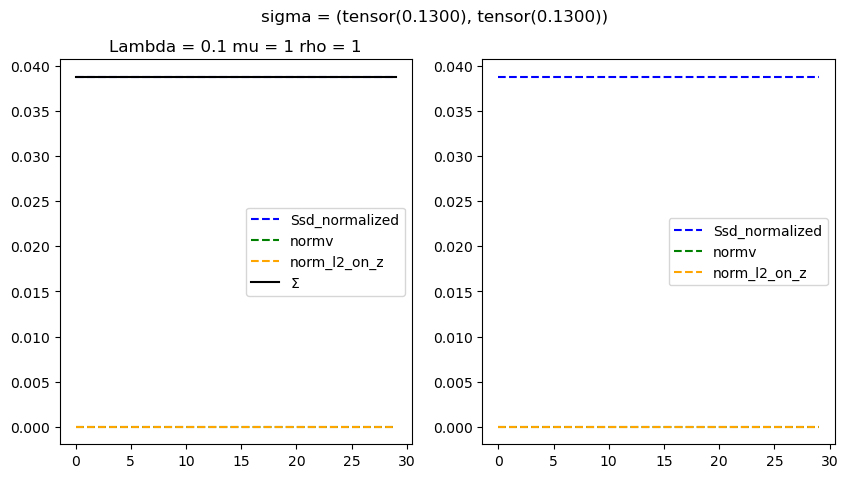

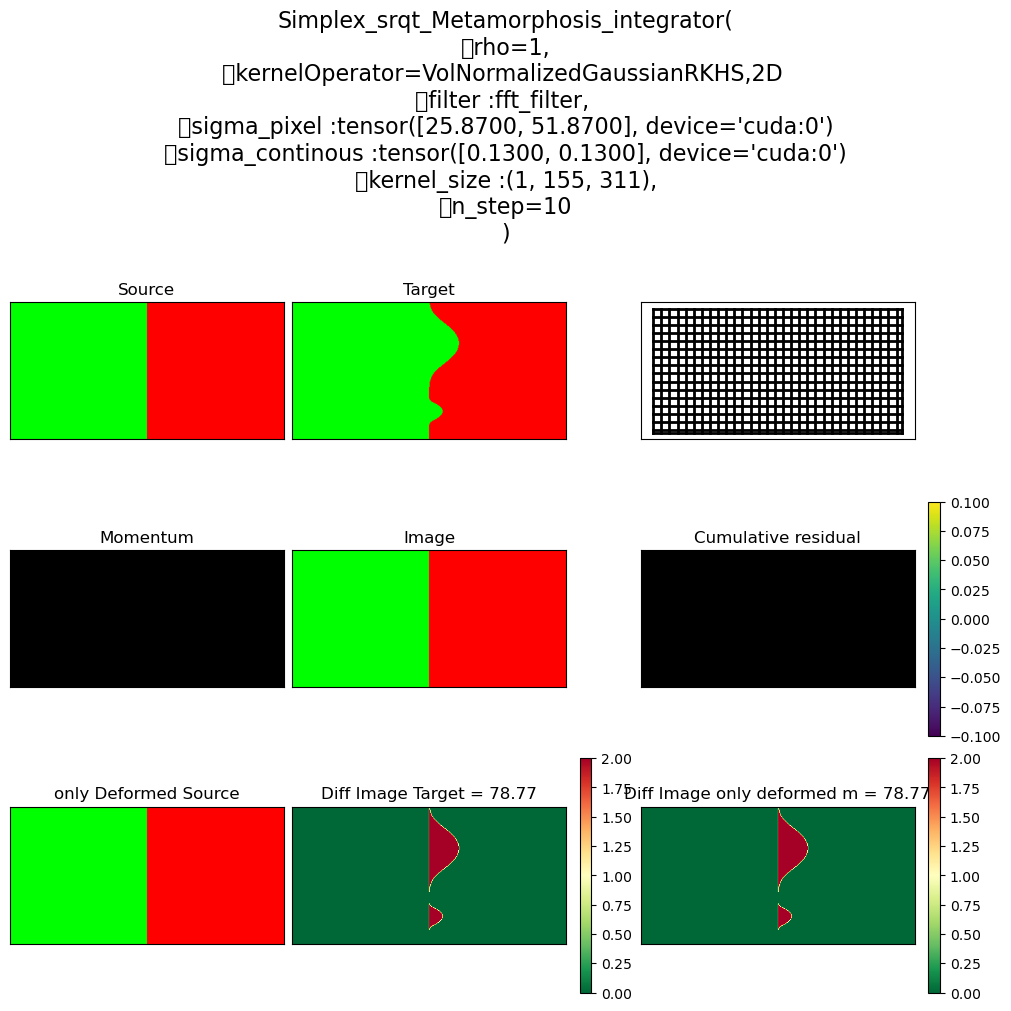

In [6]:
sigma_exp = .1
source,target,name = experience_1((200,400),sigma_exp)
# source,target,name = experience_2((200,400),sigma_exp)

source = source.to(device).contiguous()#.to(torch.double)
target = target.to(device).contiguous()#.to(torch.double)
save = True

# Metamoprhosis params
rho = 1

data_cost = mt.Ssd_normalized(target)
dx_convention = 'pixel'
# kernels params
dx = tuple([1./(s-1) for s in source.shape[2:]])
# sigma_c,window = .05, .0099
# s_list = torch.linspace(sigma_c - window,sigma_c + window,7)
s_list = torch.linspace(.05,.13,10)
# s_list = [0.0455]
# s_list = [0.043999]
# s_list = [.08]

# s_list = [0.1]

print(f"s_list: {s_list}")
score_stock = []
for s in s_list:
    print(f"\ns: {s}"+ '<'*10)
    # dx = (1,1)
    sigma = (s,s)
    kernelOperator = rk.VolNormalizedGaussianRKHS(
        sigma=sigma,
        sigma_convention='continuous', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        dx=dx,
        border_type='constant'
    )
    print(kernelOperator)
    # kernelOperator.plot()
    # plt.show()
        
    momentum_ini = torch.zeros_like(source)
    momentum_ini.requires_grad = True

    ic.disable()
    mr = mt.simplex_metamorphosis(source.clone(),target.clone(),momentum_ini,kernelOperator,rho,
                               n_step=10,
                               n_iter=30,
                               grad_coef=1,
                               cost_cst=.1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = True
    )
    if mr.to_analyse == 'Integration diverged':
        score_stock.append(
        {
            'sigma_pixel':mr.mp.kernelOperator.sigma,
            'sigma_continuous':mr.mp.kernelOperator.sigma_continuous,
            'image_size': source.shape,
            'norm_V':'diverged',
            'norm_z':'diverged',
            'rho': rho,
            'total_cost':'diverged'
        }
    )
    else:
        fig_cost,_ =mr.plot_cost()
        if save:
            fig_cost.suptitle(f'sigma = {sigma}')
            fig_cost.savefig(path_save + f'{name}_varySigma_cost_sigma_{sigma}_rho_{rho}.png')
        
        # plt.show()
        
        score_stock.append(
            {
                'sigma_pixel':mr.mp.kernelOperator.sigma,
                'sigma_continuous':mr.mp.kernelOperator.sigma_continuous,
                'image_size': source.shape,
                'norm_V':mr.norm_v_2,
                'norm_z':mr.norm_l2_on_z,
                'rho': rho,
                'total_cost':mr.total_cost
            }
        )
        
        #%%
        # ic.enable()
        print(score_stock)
        print("\n")
        end_result = plot_endresult(mr,save=save, return_all=True,
                                    filename=f"{name}_varySigma_{sigma[0]:.3f}_rho_{rho}_summary.png")
        plt.show()



### analyse results

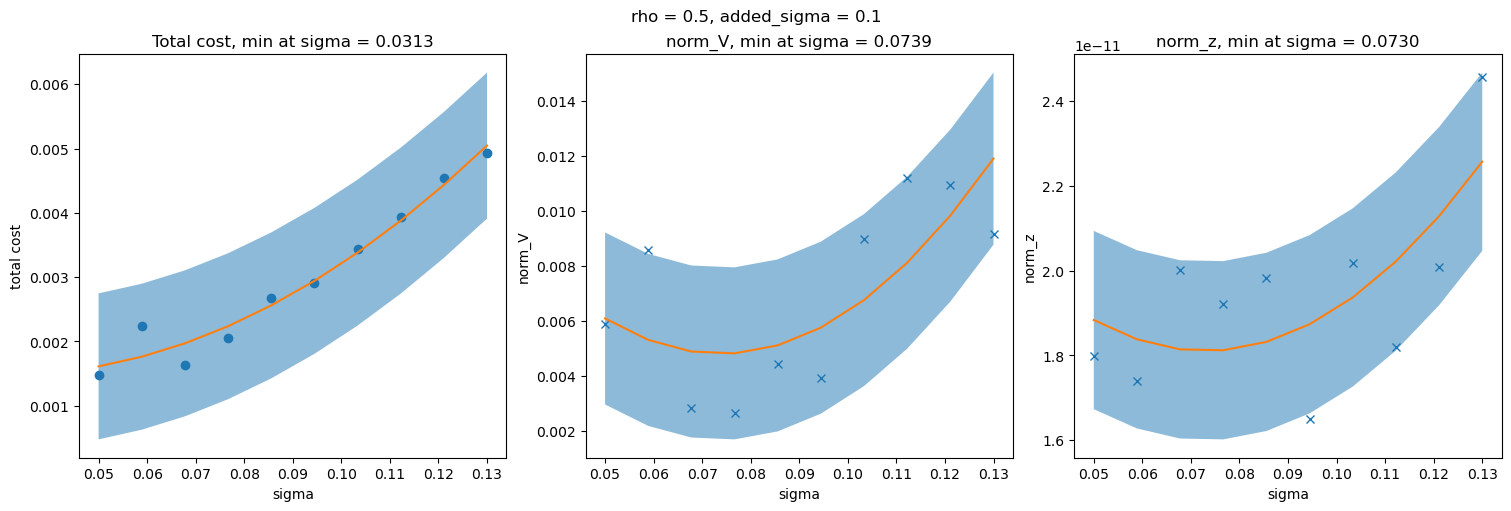

In [99]:


sigma_list = np.array([float(ss['sigma_continuous'][0]) for ss in score_stock if not ss['norm_V'] == 'diverged'])
norm_v_list = np.array([float(ss['norm_V']) for ss in score_stock if not ss['norm_V'] == 'diverged'])
norm_z_list = np.array([float(ss['norm_z']) for ss in score_stock if not ss['norm_V'] == 'diverged'])
total_cost_list = np.array([float(ss['total_cost']) for ss in score_stock if not ss['norm_V'] == 'diverged'])

sigma_sort = np.argsort(sigma_list)
sigma_list = sigma_list[sigma_sort]
norm_v_list = norm_v_list[sigma_sort]
norm_z_list = norm_z_list[sigma_sort]
total_cost_list = total_cost_list[sigma_sort]


nv_params = np.polyfit(sigma_list,norm_v_list,2)
norm_v_model = np.polyval(nv_params,sigma_list)
nv_min = - nv_params[1] / (2*nv_params[0])

nz_params = np.polyfit(sigma_list,norm_z_list,2)
norm_z_model = np.polyval(nz_params,sigma_list)
nz_min = - nz_params[1] / (2*nz_params[0])

tc_params = np.polyfit(sigma_list,total_cost_list,2)
total_cost_model = np.polyval(tc_params,sigma_list)
tc_min = - tc_params[1] / (2*tc_params[0])

fig, ax = plt.subplots(1,3,figsize=(15,5),constrained_layout = True)
fig.suptitle(f"rho = {rho}, added_sigma = {sigma_exp}")

ax[0].plot(sigma_list, total_cost_list,'o')
ax[0].plot(sigma_list, total_cost_model)
ax[0].fill_between(sigma_list, total_cost_model - total_cost_list.std() ,total_cost_model + total_cost_list.std(),alpha=.5)
ax[0].set_xlabel("sigma")
ax[0].set_ylabel("total cost")
ax[0].set_title('Total cost, min at sigma = {:.4f}'.format(tc_min))

ax[1].plot(sigma_list, norm_v_list,'x')
ax[1].plot(sigma_list, norm_v_model)
ax[1].plot()
ax[1].fill_between(sigma_list, norm_v_model - norm_v_list.std() ,norm_v_model + norm_v_list.std(),alpha=.5)
# ax[1].fill_between(sigma_list, norm_v_list - norm_v_err ,norm_v_list + norm_v_err,alpha=.5)
ax[1].set_xlabel("sigma")
ax[1].set_ylabel("norm_V")
ax[1].set_title('norm_V, min at sigma = {:.4f}'.format(nv_min))

ax[2].plot(sigma_list, norm_z_list,'x')
ax[2].plot(sigma_list, norm_z_model)
ax[2].fill_between(sigma_list, norm_z_model - norm_z_list.std() ,norm_z_model + norm_z_list.std(),alpha=.5)
ax[2].set_xlabel("sigma")
ax[2].set_ylabel("norm_z")
ax[2].set_title('norm_z, min at sigma = {:.4f}'.format(nz_min))
plt.show()
fig.savefig(path_save+f"*sigma_influance_on_metrics_rho_{rho}_sigmaExp_{sigma_exp}.png")

## Make size vary



In [84]:
import gc
gc.collect()


72830


s: 0.5<<<<<<<<<<
(100, 200)
tensor(0.0280)
kernel_h : torch.Size([1, 41]), kernel_w : torch.Size([1, 83])
torch.Size([1, 41])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([ 6.9300, 13.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 41, 83)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9568189607974844..2.2460689328062666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7600379586219788..1.04694664478302].



Computation of forward done in  0:00:01s and 0.383cents  s
{'sigma_pixel': tensor([ 6.9300, 13.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 100, 200]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0307, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




/tmp/ipykernel_52930/1803803286.py:147: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


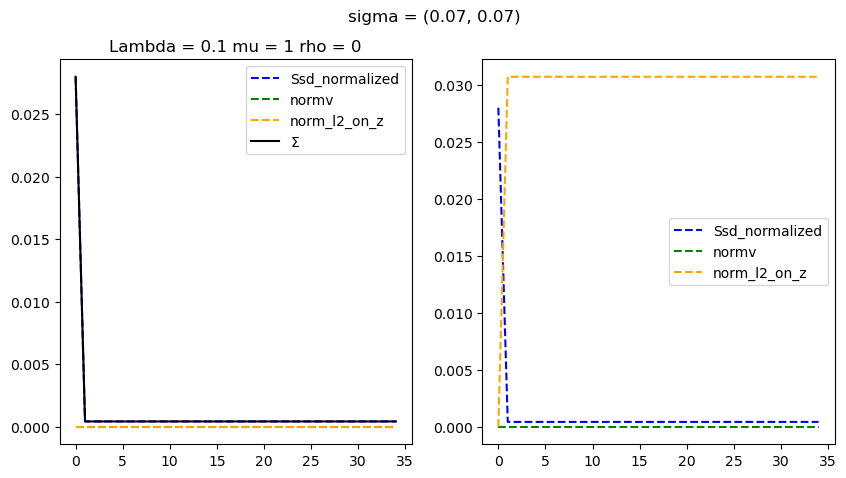

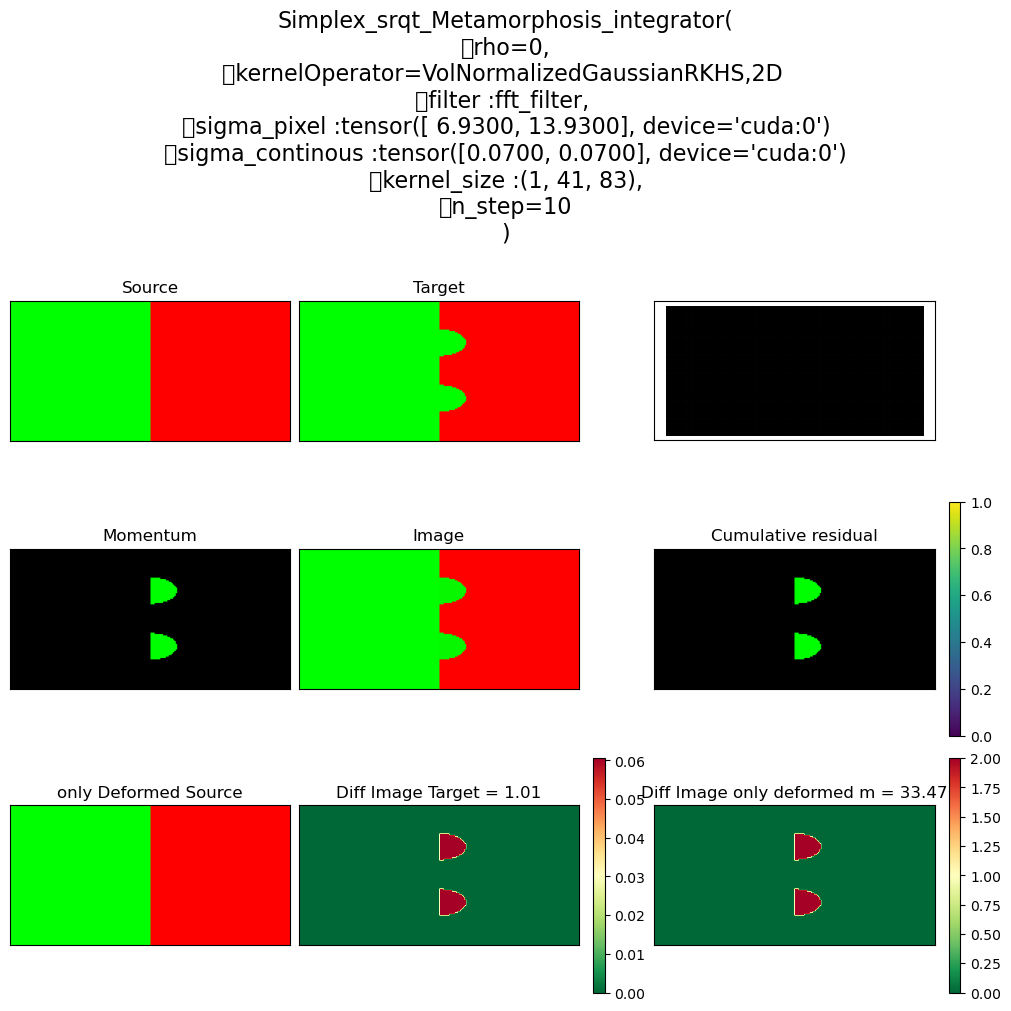


s: 1<<<<<<<<<<
(200, 400)
tensor(0.0281)
kernel_h : torch.Size([1, 83]), kernel_w : torch.Size([1, 167])
torch.Size([1, 83])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([13.9300, 27.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 83, 167)

Computation of forward done in  0:00:02s and 0.574cents  s
{'sigma_pixel': tensor([13.9300, 27.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 200, 400]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0308, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9664648564523737..2.2543909834926144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7635242938995361..1.0480352640151978].


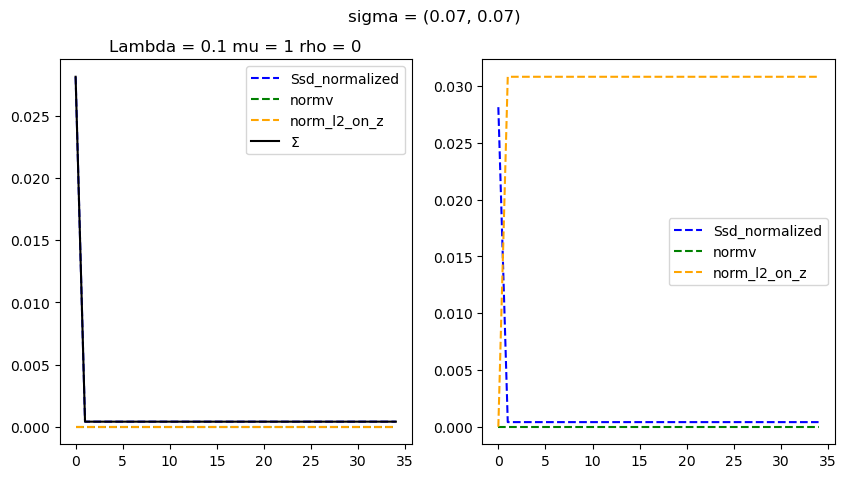

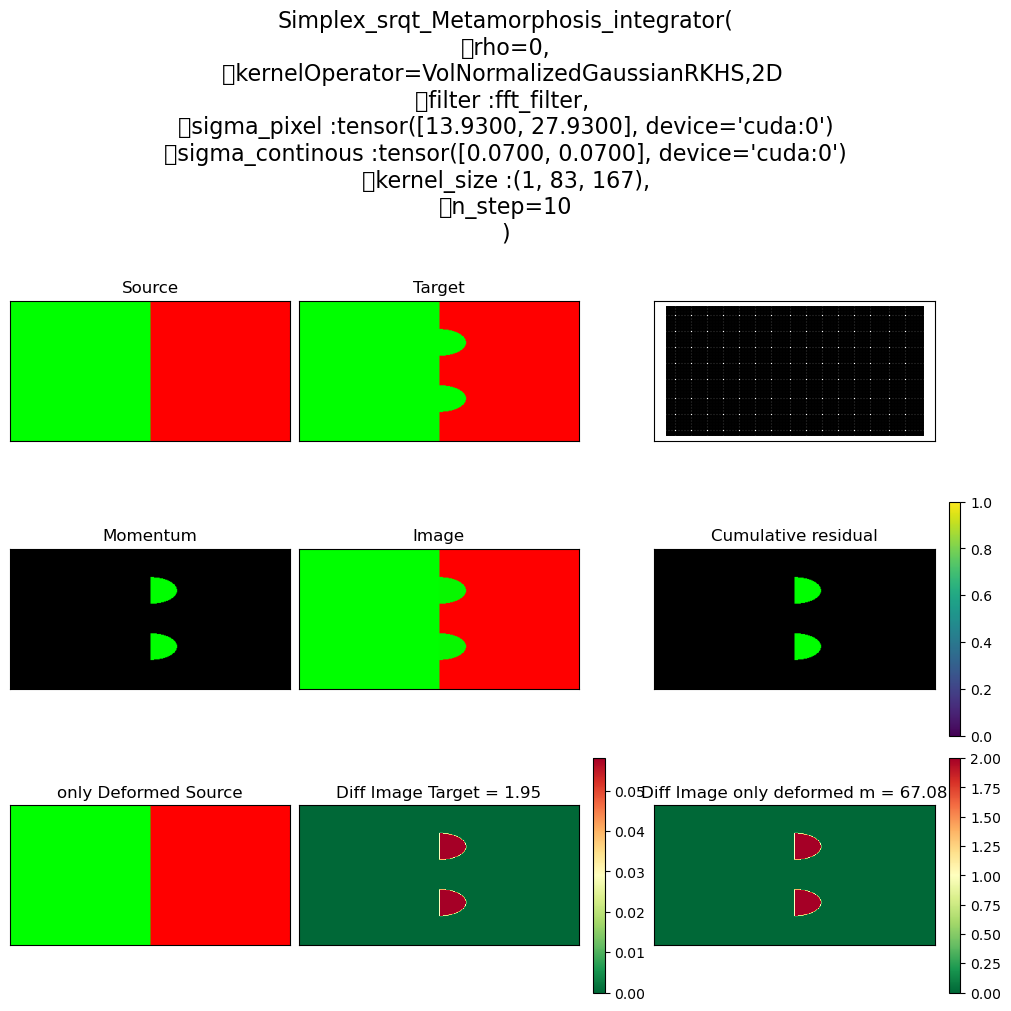


s: 1.5<<<<<<<<<<
(300, 600)
tensor(0.0281)
kernel_h : torch.Size([1, 125]), kernel_w : torch.Size([1, 251])
torch.Size([1, 125])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([20.9300, 41.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 125, 251)

Computation of forward done in  0:00:03s and 0.279cents  s
{'sigma_pixel': tensor([20.9300, 41.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 300, 600]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0308, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9676446258495122..2.2554048148641326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7639493942260742..1.0481669902801514].


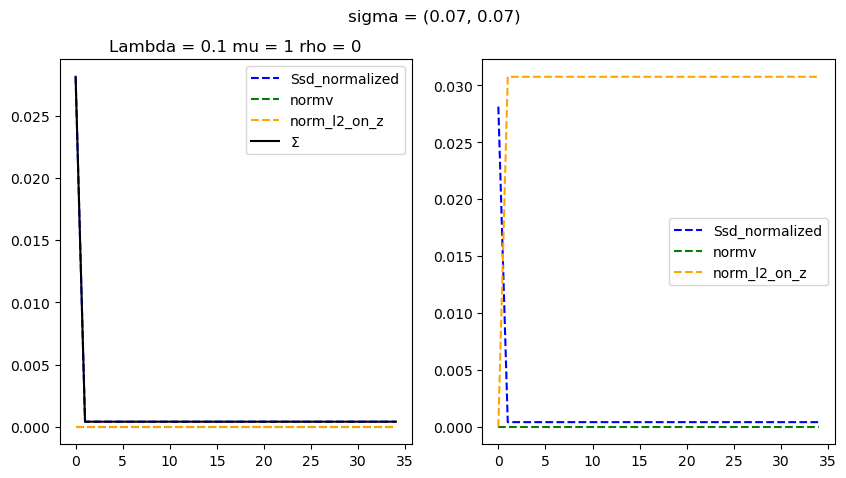

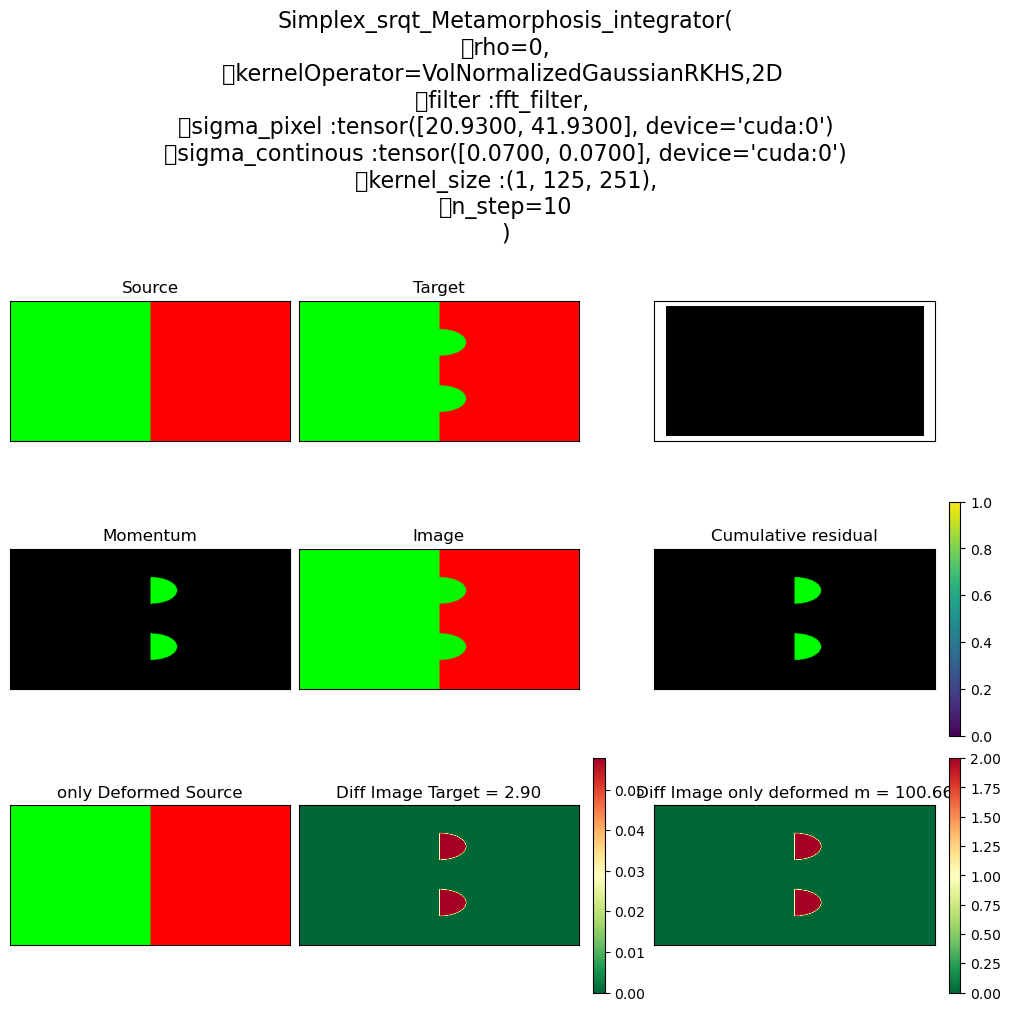


s: 2<<<<<<<<<<
(400, 800)
tensor(0.0282)
kernel_h : torch.Size([1, 167]), kernel_w : torch.Size([1, 335])
torch.Size([1, 167])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([27.9300, 55.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 167, 335)

Computation of forward done in  0:00:07s and 0.340cents  s
{'sigma_pixel': tensor([27.9300, 55.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 400, 800]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0315, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0076436375728293..2.289230476194603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7781846523284912..1.0524743795394897].


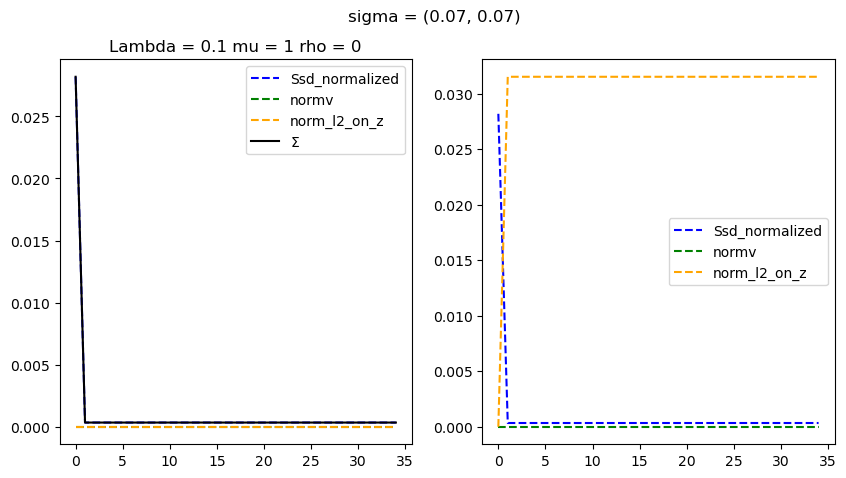

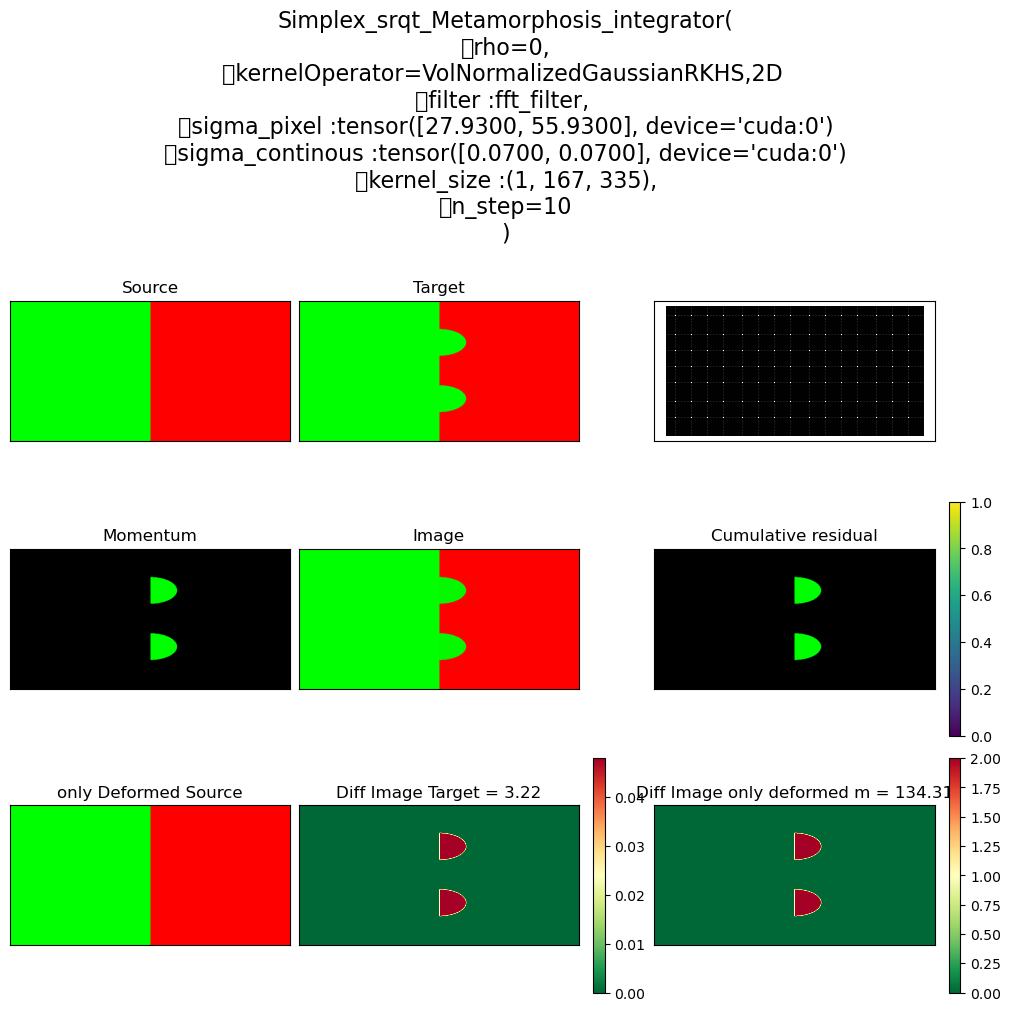


s: 2.2<<<<<<<<<<
(440, 880)
tensor(0.0282)
kernel_h : torch.Size([1, 185]), kernel_w : torch.Size([1, 369])
torch.Size([1, 185])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([30.7300, 61.5300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 185, 369)

Computation of forward done in  0:00:07s and 0.508cents  s
{'sigma_pixel': tensor([30.7300, 61.5300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 440, 880]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0302, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9374673695082028..2.2291812003445903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7530187964439392..1.0447477102279663].


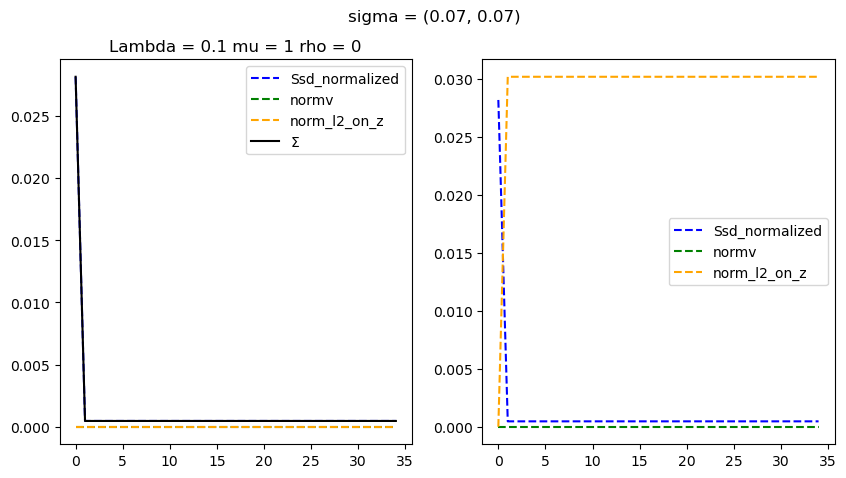

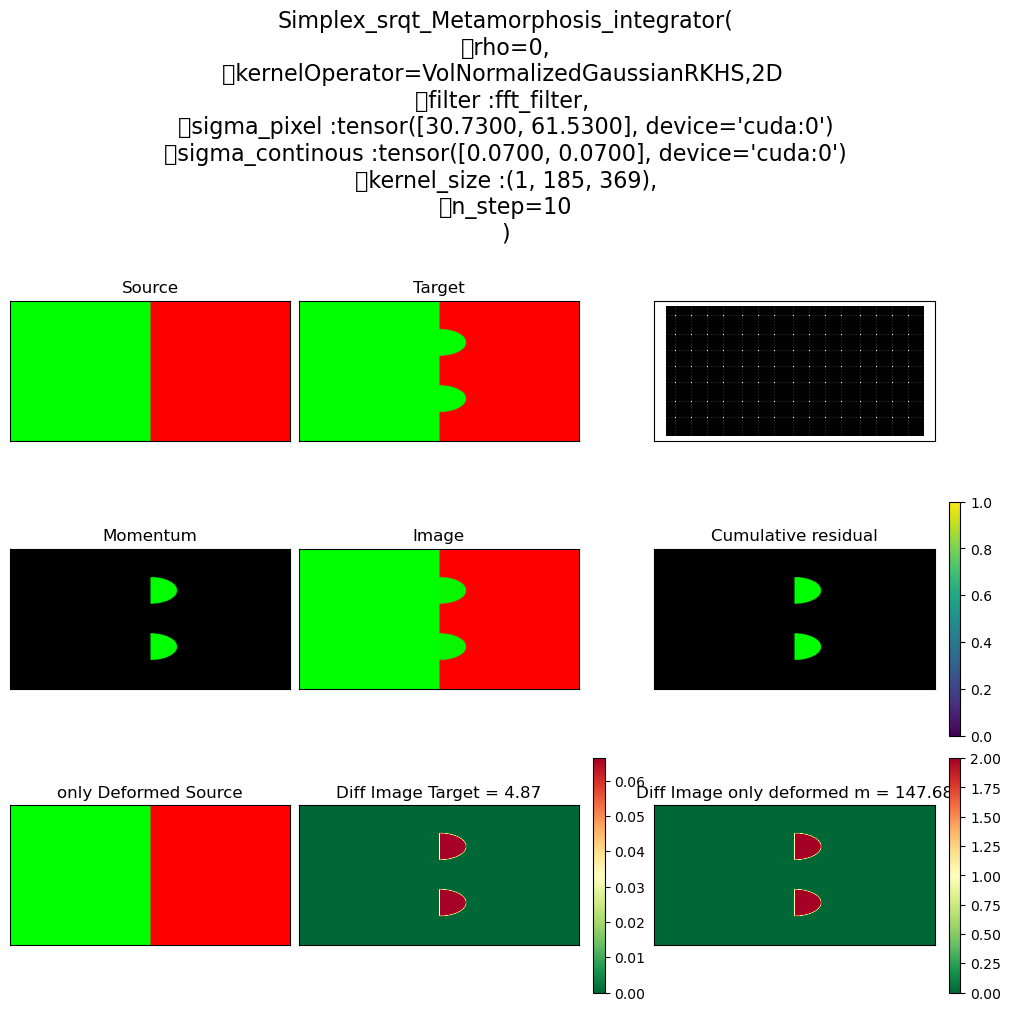


s: 2.5<<<<<<<<<<
(500, 1000)
tensor(0.0282)
kernel_h : torch.Size([1, 209]), kernel_w : torch.Size([1, 419])
torch.Size([1, 209])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([34.9300, 69.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 209, 419)

Computation of forward done in  0:00:13s and 0.260cents  s
{'sigma_pixel': tensor([34.9300, 69.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 500, 1000]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0308, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0035, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9682954982824373..2.255953495261211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7641911506652832..1.0482487678527832].


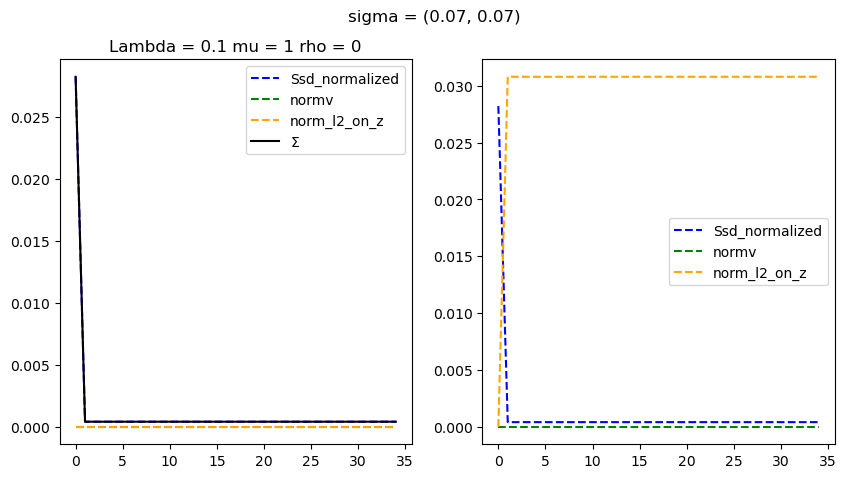

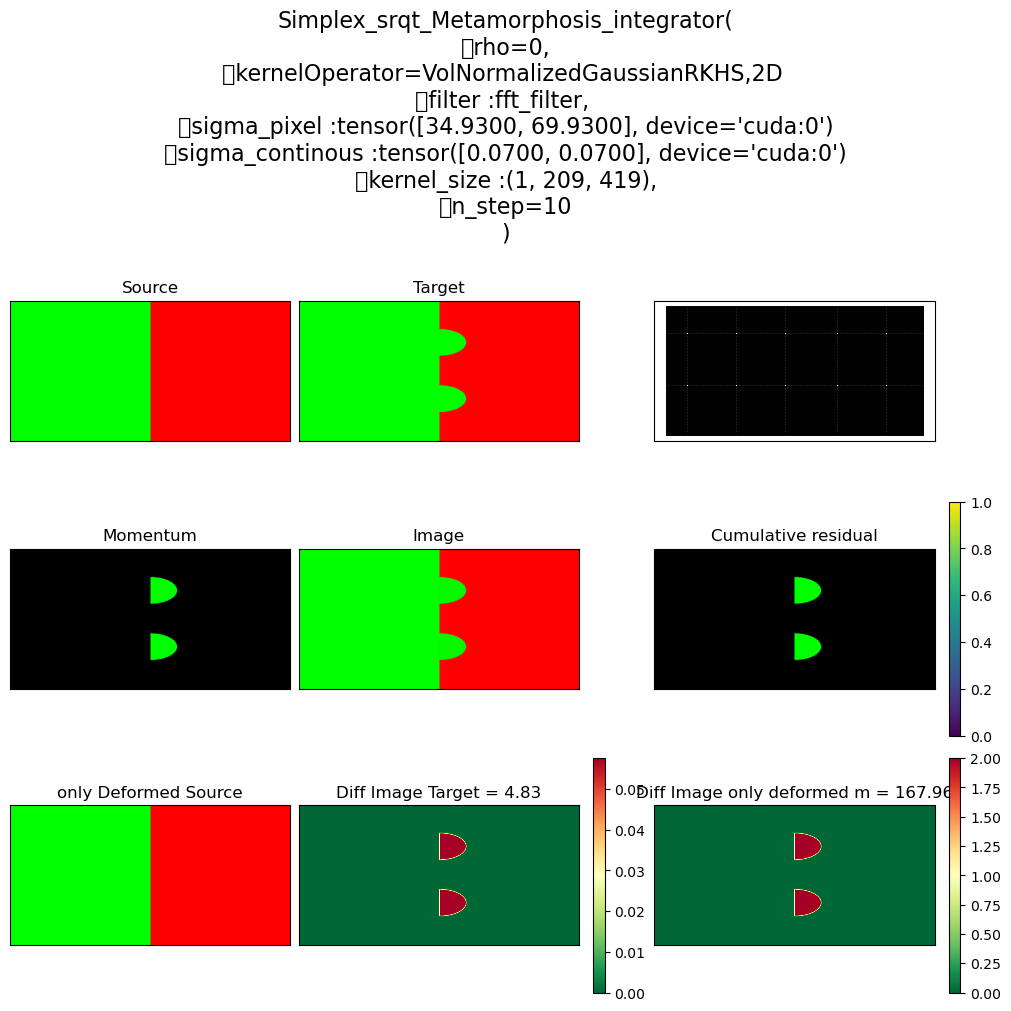


s: 3<<<<<<<<<<
(600, 1200)
tensor(0.0282)
kernel_h : torch.Size([1, 251]), kernel_w : torch.Size([1, 503])
torch.Size([1, 251])
VolNormalizedGaussianRKHS,2D 
	filter :fft_filter, 
	sigma_pixel :tensor([41.9300, 83.9300])
	sigma_continous :tensor([0.0700, 0.0700])
	kernel_size :(1, 251, 503)

Computation of forward done in  0:00:16s and 0.722cents  s
{'sigma_pixel': tensor([41.9300, 83.9300], device='cuda:0'), 'sigma_continuous': tensor([0.0700, 0.0700], device='cuda:0'), 'image_size': torch.Size([1, 2, 600, 1200]), 'norm_V': tensor(0., device='cuda:0', grad_fn=<MulBackward0>), 'norm_z': tensor(0.0343, device='cuda:0', grad_fn=<MulBackward0>), 'rho': 0, 'total_cost': tensor(0.0036, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1613583556605638..2.410288645627292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8298475742340088..1.0662356615066528].


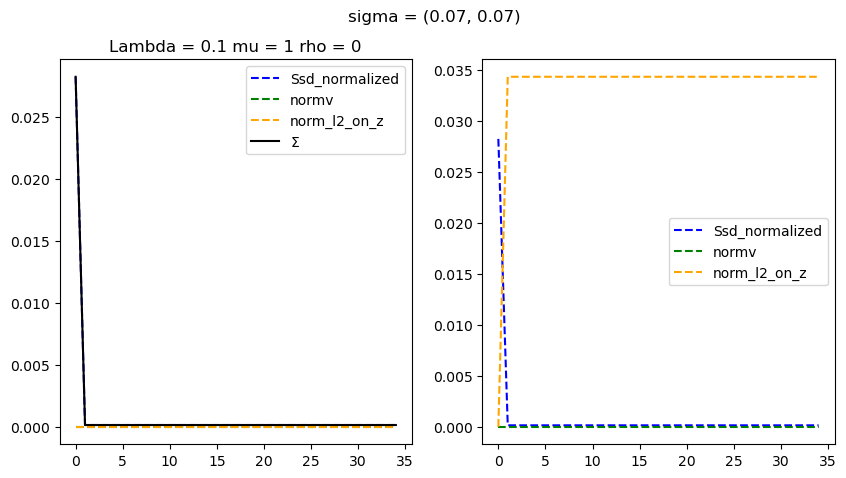

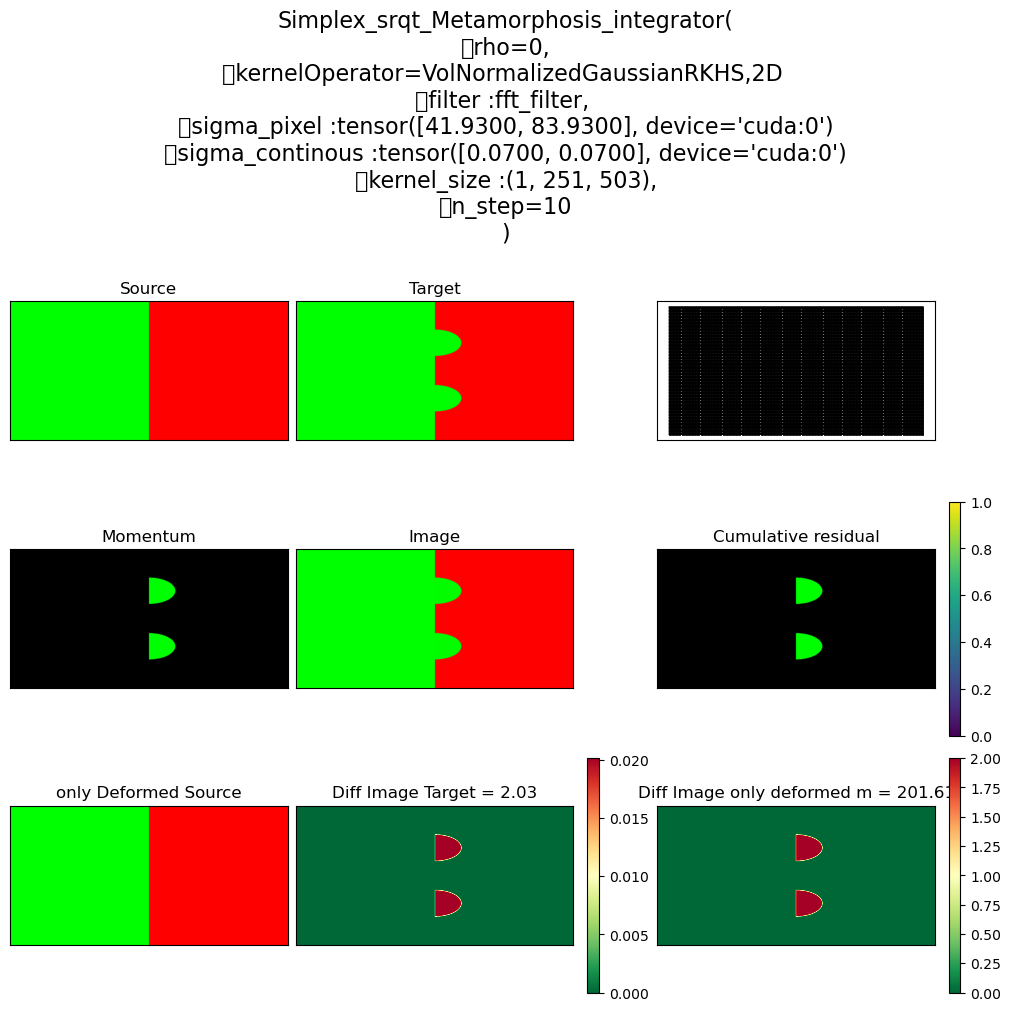

In [85]:
save = True
sigma_add = .07
rho = 0
dx_convention = 'pixel'

sigma = (sigma_add,sigma_add)

size_ref = (200,400)
s_list = [.5,1,1.5,2,2.2,2.5,3]
# s_list = [,2.2]
# s_list = [1.5,4]
# s_list = [.5]
# ic.enable()
# score_stock = []
# del mr
# torch.cuda.empty_cache()
for s in s_list:
    print(f"\ns: {s}"+ '<'*10)
    size = (int(size_ref[0]*s),int(size_ref[1]*s))
    print(size)
    source, target  = experience_1(size,sigma_add)
    source = source.to(device).contiguous()#.to(torch.double)
    target = target.to(device).contiguous()#.to(torch.double)
    data_cost = mt.Ssd_normalized(target)

    dx = tuple([1./(s-1) for s in source.shape[2:]])

    kernelOperator = rk.VolNormalizedGaussianRKHS(
        sigma=sigma,
        sigma_convention='continuous', # by passing 'continuous' we specify that sigma is continuous and compute sigma_pixel using dx
        dx=dx,
        border_type='constant'
    )
    print(kernelOperator)
    # kernelOperator.plot()
    # plt.show()

    momentum_ini = torch.zeros_like(source)
    momentum_ini.requires_grad = True
    mr = mt.simplex_metamorphosis(source.clone(),target.clone(),momentum_ini,kernelOperator,rho,
                               n_step=10,
                               n_iter=35,
                               grad_coef=1,
                               cost_cst=.1,
                               plot=False,
                               data_term = data_cost,
                               dx_convention = dx_convention,
                                safe_mode = True
    )
    if mr.to_analyse == 'Integration diverged':
        score_stock.append(
        {
            'sigma_pixel':mr.mp.kernelOperator.sigma,
            'sigma_continuous':mr.mp.kernelOperator.sigma_continuous,
            'image_size': source.shape,
            'norm_V':'diverged',
            'norm_z':'diverged',
            'rho': rho,
            'total_cost':'diverged'
        }
    )
    else:
        fig_cost,_ =mr.plot_cost()
        if save:
            fig_cost.suptitle(f'sigma = {sigma}')
            fig_cost.savefig(path_save + f'cost_sigma_ {sigma}.png')

        # plt.show()

        score_stock.append(
            {
                'sigma_pixel':mr.mp.kernelOperator.sigma,
                'sigma_continuous':mr.mp.kernelOperator.sigma_continuous,
                'image_size': source.shape,
                'norm_V':mr.norm_v_2,
                'norm_z':mr.norm_l2_on_z,
                'rho': rho,
                'total_cost':mr.total_cost
            }
        )
        
        #%%
        print(score_stock[-1])
        print("\n")
        end_result = plot_endresult(mr,save=save, return_all=True,
                                    filename=f"varySize_{size}_sigma_{sigma[0]:.3f}_summary")
        plt.show()
    del mr
    torch.cuda.empty_cache()
    gc.collect()

### Analyse results

6


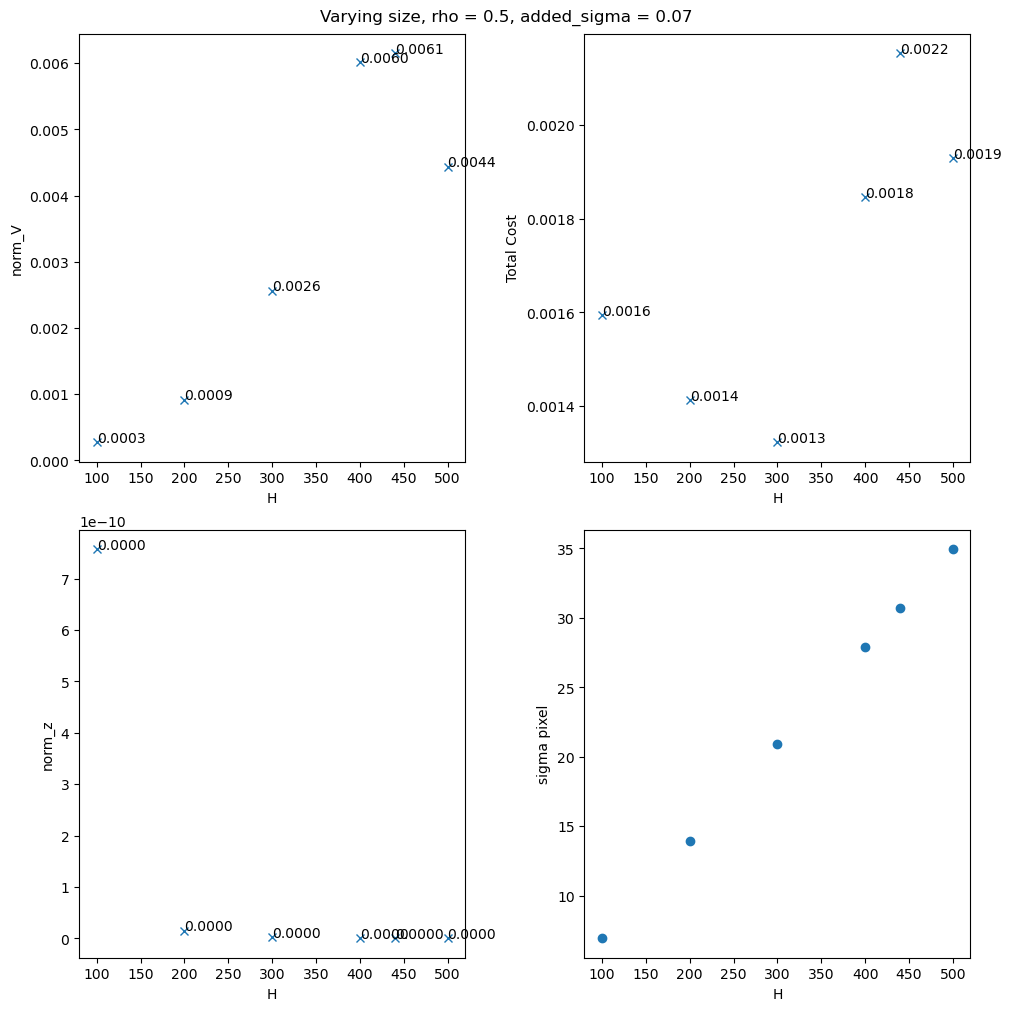

In [87]:
rho_to_show = 0.5
sigma_list = np.array(
    [float(ss['sigma_pixel'][0]) for ss in score_stock 
     if (not ss['norm_V'] == 'diverged' and ss['rho'] == rho_to_show)]
)
norm_v_list = np.array(
    [float(ss['norm_V']) for ss in score_stock 
     if (not ss['norm_V'] == 'diverged' and ss['rho'] == rho_to_show)]
)
norm_z_list = np.array(
    [float(ss['norm_z']) for ss in score_stock 
     if (not ss['norm_V'] == 'diverged' and ss['rho'] == rho_to_show)]
)
total_cost_list = np.array(
    [float(ss['total_cost']) for ss in score_stock 
     if (not ss['norm_V'] == 'diverged' and ss['rho'] == rho_to_show)]
)
H_list = np.array(
    [float(ss['image_size'][2]) for ss in score_stock 
     if (not ss['norm_V'] ==  'diverged'and ss['rho'] == rho_to_show)]
)
print(len(H_list))


H_sort = np.argsort(H_list)
H_list = H_list[H_sort]
sigma_list = sigma_list[H_sort]
norm_v_list = norm_v_list[H_sort]
norm_z_list = norm_z_list[H_sort]
total_cost_list = total_cost_list[H_sort]


fig,ax = plt.subplots(2,2,figsize=(10,10),constrained_layout=True)
ax[0,0].plot(H_list,norm_v_list,"x")
ax[0,0].set_xlabel("H")
ax[0,0].set_ylabel("norm_V")
for i in range(len(H_list)):
    ax[0,0].annotate(f"{norm_v_list[i]:.4f}",(H_list[i],norm_v_list[i]))

ax[0,1].plot(H_list,total_cost_list,"x")
ax[0,1].set_xlabel("H")
ax[0,1].set_ylabel("Total Cost")
for i in range(len(H_list)):
    ax[0,1].annotate(f"{total_cost_list[i]:.4f}",(H_list[i],total_cost_list[i]))

ax[1,0].plot(H_list,norm_z_list,"x")
ax[1,0].set_xlabel("H")
ax[1,0].set_ylabel("norm_z")
for i in range(len(H_list)):
    ax[1,0].annotate(f"{norm_z_list[i]:.4f}",(H_list[i],norm_z_list[i]))

ax[1,1].plot(H_list,sigma_list,"o")
ax[1,1].set_xlabel("H")
ax[1,1].set_ylabel("sigma pixel")
fig.suptitle(f"Varying size, rho = {rho_to_show}, added_sigma = {sigma_add}")
plt.show()
fig.savefig(path_save+f"*size_influance_on_metrics_rho_{rho_to_show}_sigmaExp_{sigma_add}.png")